# Homework 1 (Due Sep 23, 2025 by Noon) 


## Problem 1 (50 pts)

###  Fitting a Line using a Maximum Likelihood Estimator

You've learned how to create L- and M- estimators and use them to estimate the parameters of a model. Generally, we want some kind of uncertainty estimate for our models, and therefore M-estimators and maximum likelihood estimators in particular are useful.

Assume the scatter in our measurements (the residuals) is generated by:

>$ y_i = a x_i + b + r_i $

where $r_i$ is drawn from $N(0, \sigma)$. Here, $\sigma$ is the error the measurement induces.

To use an M-estimator/MLE, you have to specify the likelihood function. First, the probability $p(y_i|x_i, M(a, b), \sigma)$ that a particular point $y_i$ would be measured is just the normal distribution:

>$ p(y_i|x_i, M(a, b), \sigma) = N(y_i - M(x)|\sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{(y_i - M(x_i))^2}{2 \sigma^2} \right) $.

Given what we discussed in class, we can write down the $\ln L$
You can use one of the estimators we discussed in the lecture, but you should be aware that the dataset can have outliers. 


Once you write down the $\ln L$ in terms of the model parameters, $a$ and $b$, this is the expression that you now minimize with respect to $a$ and $b$ to find ML estimators for those parameters. 


## MLE with outliers

Let's apply the MLE to data with uncertainties where these uncertainties include outliers. 
I've defined a dataset below:

Your mission is to:

- write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)
- Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)
- Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) and make a QQ plot of the residuals (10 pts)
- Define a new likelihood function that implements your favorite robust loss function, also incorporating the measurement uncertainties $dy$ (10 pts)
- Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, except now use scipy.optimize.fmin instead of a grid search, and you know the drill by now - QQ plot of the residuals (10 pts)

Recommended reading: David Hogg, Jo Bovy, and Dustin Lang: "Data analysis recipes: Fitting a model to data", 2010: https://arxiv.org/abs/1008.4686

In [167]:
%matplotlib inline

In [168]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import statsmodels.api as sm
from astroML.datasets import fetch_hogg2010test

# this just makes plots a bit easier on my laptop - disable as needed
%config InlineBackend.figure_format='retina'

#------------------------------------------------------------
# Get data: this includes outliers
data = fetch_hogg2010test()
x = data['x']
y = data['y']
dy = data['sigma_y']

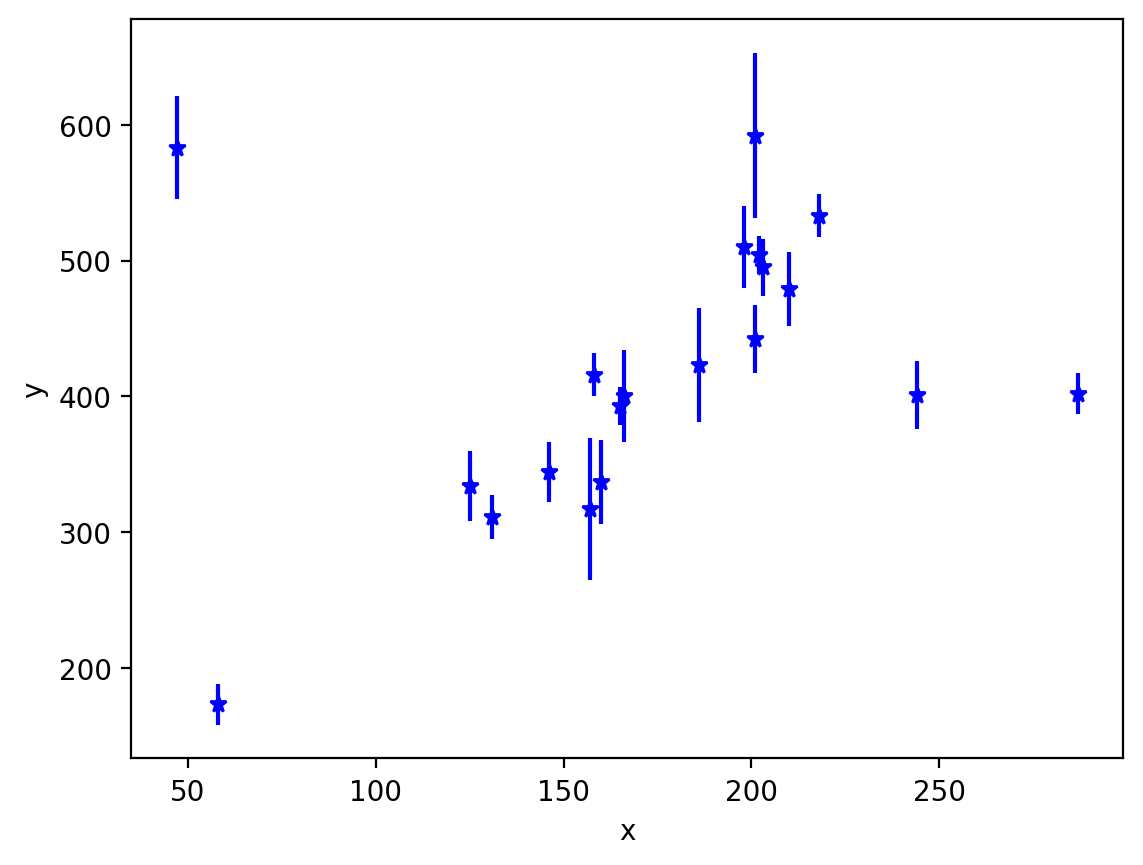

In [169]:
#First i wanna see how the data looks like
plt.errorbar(x,y, yerr=dy, color = 'blue',marker ='*', linestyle = 'None')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### I will explain my thought process as i work on them. this helps me code better.

In [170]:
#write a function that computes the squared loss, and incorporates the uncertainties on the measurements, $dy$ (10 pts)

By squared loss + incorporating uncertainties, they mean chi2 because inside the question I see the equation: $( -{(y_i - M(x_i))^2})$. In our case, $\sigma_i = dy_i$ so we will divide by $dy^2$ to account for the uncertainties/weights inside the loss function. So finally what we get is the $\chi^2 = \sum (\frac{y_i - M(x_i)}{dy})^2$


In [171]:
def model(x, a, b):
    return a*x + b

In [172]:
def chi2(a, b, x, y, dy):
    chi2_val = np.sum(((y - (model(x,a,b)))/dy)**2)
    return chi2_val

In [173]:
#Fit a line to the full sample by evaluating this likelihood on a grid of a, b (10 pts)

Upon eyeballin I take the slope to be 410/180 ~ 2 (extremely rough). Now using b = y-ax = 410 - 2*180 = 50. My points are: a = 2, b = 50.

In [174]:
a_vals = np.linspace(0,5,50) # slope is definitely not going over 4 or worst case 5
b_vals = np.linspace(0,350,350) # intercept also wont cross 350 for sure

chi2_best = float('inf')
a_best = None
b_best = None
for a in a_vals:
    for b in b_vals:
        chi2_val = chi2(a, b, x, y, dy)
        if chi2_val < chi2_best:
            chi2_best = chi2_val
            a_best = a
            b_best = b
print(a_best, b_best)

1.1224489795918369 205.58739255014328


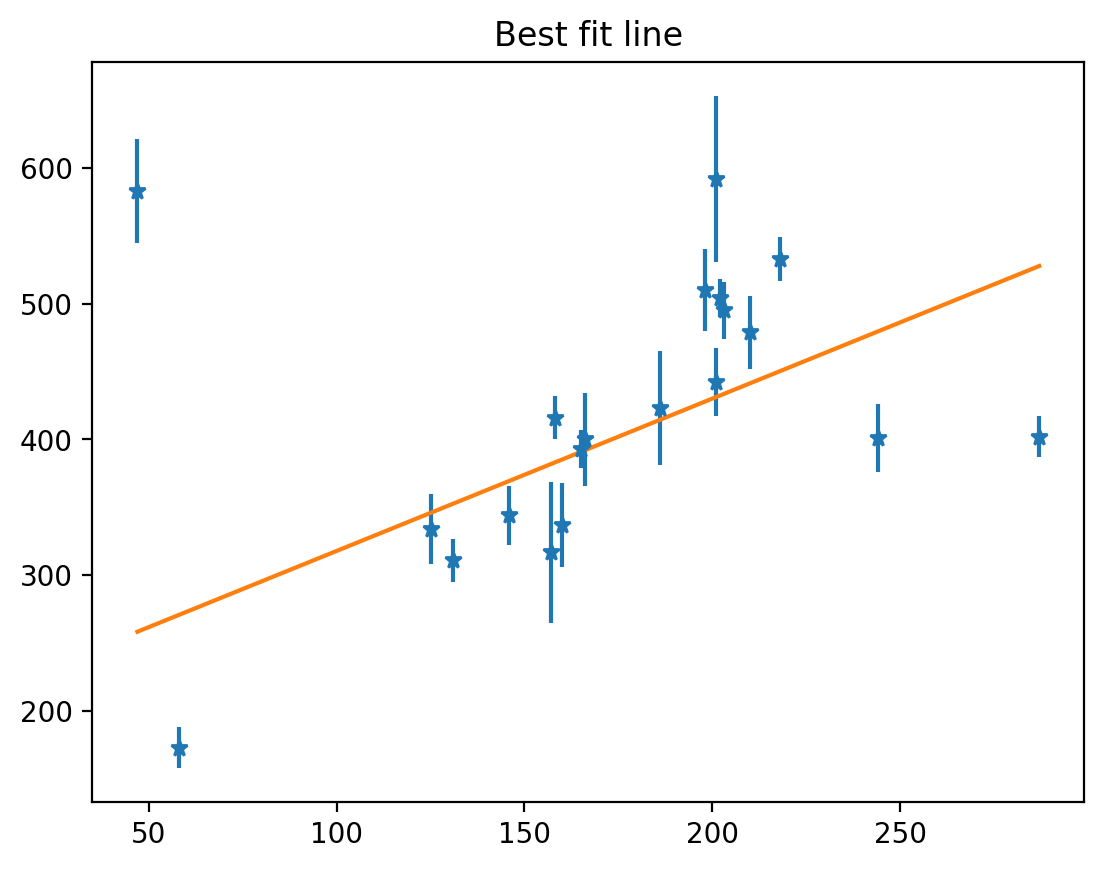

In [175]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = [np.min(x), np.max(x)]
y_vals = [model(x_vals[0], a_best, b_best),
          model(x_vals[1], a_best, b_best)]

plt.errorbar(x, y, yerr = dy, marker = '*', linestyle = 'None')
plt.plot(x_vals, y_vals)
plt.title("Best fit line")
plt.show()


In [176]:
#Use sigma-clipping or an L-estimator for outlier rejection and fit a line to the data with outliers rejected (10 pts) 
#and make a QQ plot of the residuals (10 pts)

<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qr/v9h2vyrd1fb7673fzqkh11rw0000gn/T/ipykernel_5654/1894407106.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.errorbar(x[~mask], y[~mask], yerr=dy[~mask], marker = '*', linestyle = 'None', label= f"rejected > 3$\sigma$")


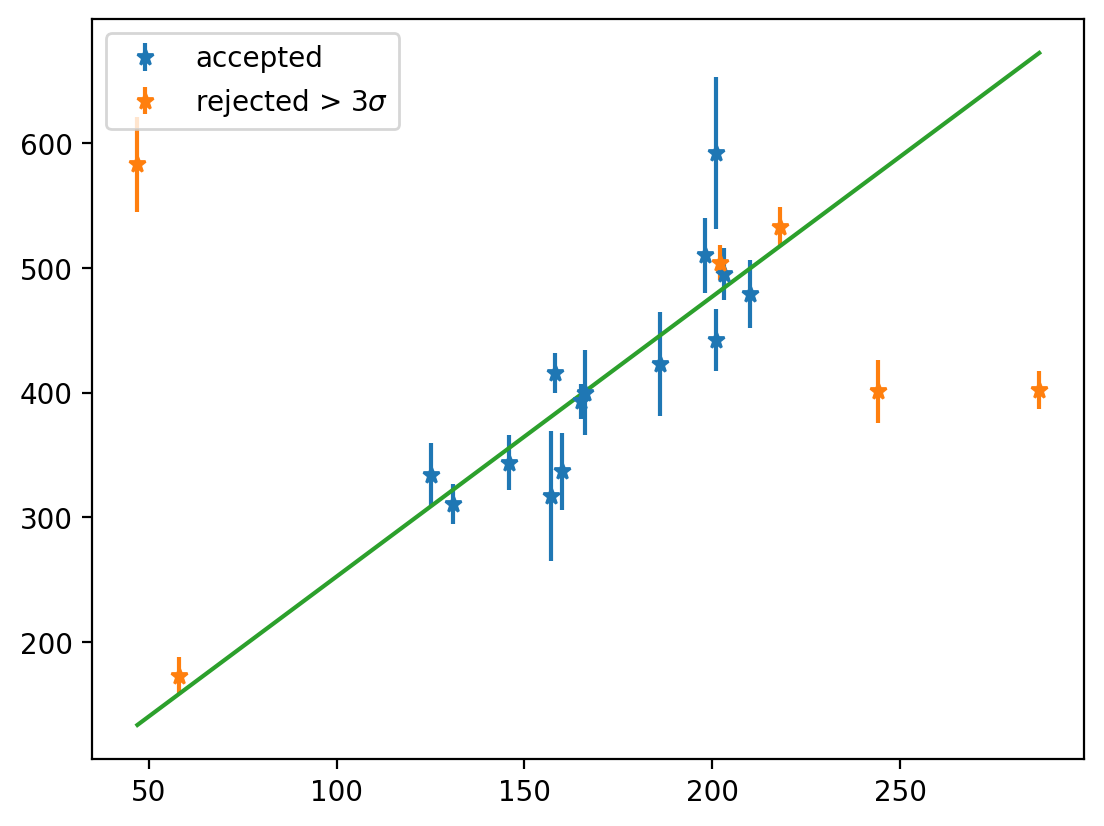

In [177]:
residuals = (y - model(x, a_best, b_best))/dy # i used normalised residuals
mask = np.abs(residuals) < 3

chi_best = float('inf')
a_masked = None
b_masked = None

for a in a_vals:
    for b in b_vals:
        chisq = chi2(a, b, x[mask], y[mask], dy[mask])
        if chisq < chi_best:
            chi_best = chisq
            a_masked = a
            b_masked = b

x_plot = [np.max(x), np.min(x)]
y_plot = [model(x_plot[0], a_masked, b_masked),
          model(x_plot[1], a_masked, b_masked)]

plt.errorbar(x[mask], y[mask], yerr = dy[mask], marker = '*', linestyle = 'None', label = 'accepted')
plt.errorbar(x[~mask], y[~mask], yerr=dy[~mask], marker = '*', linestyle = 'None', label= f"rejected > 3$\sigma$")
plt.plot(x_plot, y_plot)
plt.legend()
plt.show()

In [ ]:
print(mask) 
print(np.sum(~mask), "points rejected")

[ True False False False  True False  True False  True  True  True  True
  True  True  True  True  True  True False  True]
6 points rejected


the point of a qqplot is to check, after outlier rejection, do the residuals behave like gaussian noise

Text(0.5, 1.0, 'QQ plot of residuals')

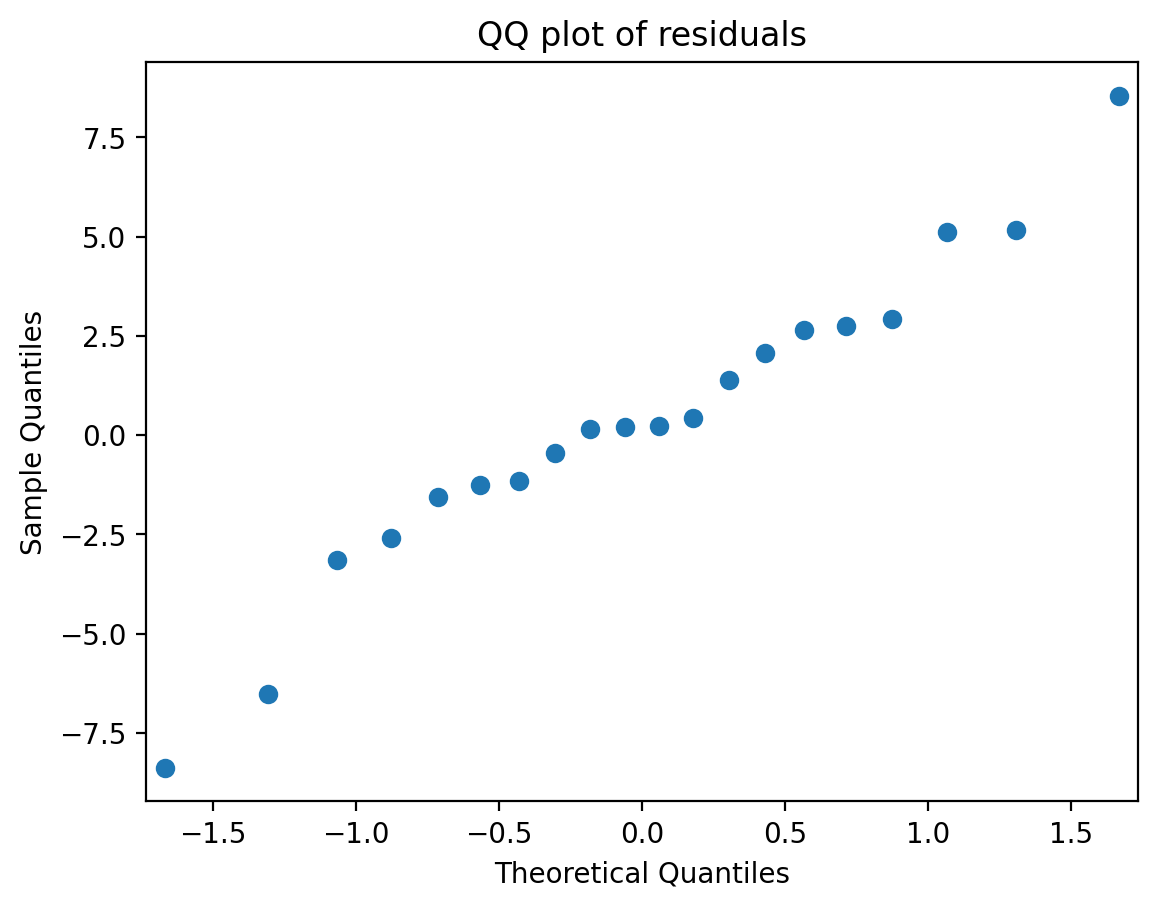

In [179]:
import statsmodels.api as sm

sm.qqplot(np.array(residuals), label='Residuals')
plt.title("QQ plot of residuals")

In [180]:
# Define a new likelihood function that implements your favorite robust loss function, 
#also incorporating the measurement uncertainties $dy$ (10 pts)

Loss functions (taken from lecture and are here for my learning): 

1) chi squared - residuals are squared and summed.    
Pros: Gives MLE if errors are truely gaussian.     
Cons: Sensitive to outliers

2) absolute error loss - residuals grow linearly.     
Pros: less sensitive to outliers, uses median as center.      
Cons: less efficient if noise is not gaussian, throws info away by not squaring.
i.e if the noise is not really gaussian, it doesn't account for "slightly bigger deviations should count a lot less probable".       

3) Huber Loss - best of both worlds.       
Pros: Combines chi2(small residuals) and absolute error loss (big residuals).     
Cons: $\delta$ dependent so has to be chosen carefully. If you pick too small, too many points become outliers and too big? you barely outweight the outliers and lose robustness.         

4) Tukey's Biweight - a better version of huber loss, super robust.         
Pros: good for messy data, small residuals -> quadratic, large residuals -> loss flattens out -> no contribution from outliers            
Cons: can throw away info if you're too aggresive with your threshold since outliers dont contribute. 


For our case, since out data is not to messy or extreme, Huber loss should do fine.


In [181]:
def huber(params,x,y,dy,delta):
    a, b = params
    res = (y - (a*x + b))/dy
    loss =np.zeros_like(res)
    for idx, r in enumerate(res):
        if np.abs(r) <= delta:
            loss[idx] = 0.5*((r)**2)
        else:
            loss[idx] = delta*(np.abs(r) - 0.5*delta)
    return np.sum(loss)


In [182]:
#Fit a new line to all of the data (no outlier rejection) with your likelihood function in the previous part, 
# except now use scipy.optimize.fmin instead of a grid search, QQ plot of the residuals (10 pts)

Optimization terminated successfully.
         Current function value: 74.401087
         Iterations: 53
         Function evaluations: 101
1.8914478773943515 86.2058062512889


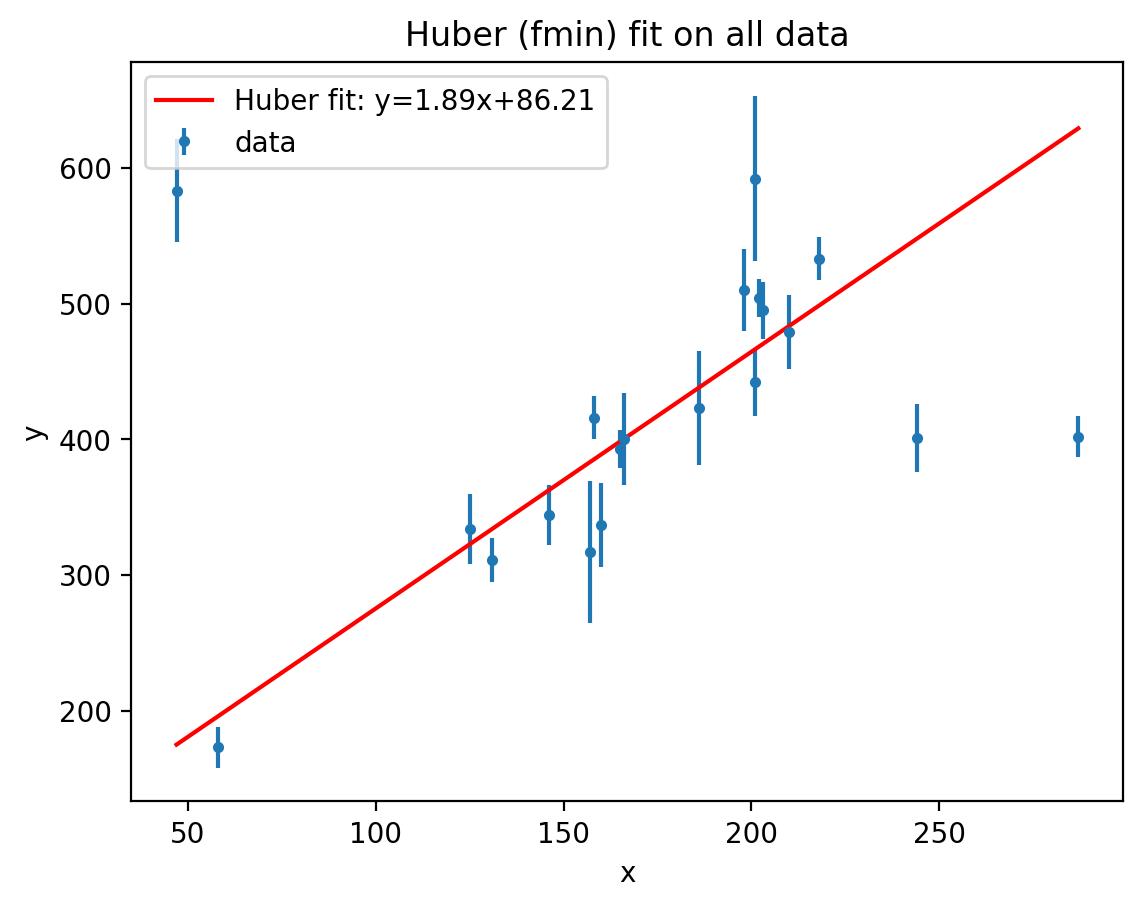

In [193]:
from scipy.optimize import fmin

guess = np.array([a_best, b_best])
huber_slope, huber_intercept = fmin(huber, guess, args = (x,y,dy,2))
print(huber_slope, huber_intercept)

x_huber = [x.min(), x.max()]
y_huber = [huber_slope*x_huber[0] + huber_intercept, huber_slope*x_huber[1] + huber_intercept]

plt.errorbar(x, y, yerr=dy, fmt='.', linestyle='none', label='data')
plt.plot(x_huber, y_huber, 'r-', label=f'Huber fit: y={huber_slope:.2f}x+{huber_intercept:.2f}')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Huber (fmin) fit on all data')
plt.legend()
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qr/v9h2vyrd1fb7673fzqkh11rw0000gn/T/ipykernel_5654/1248186030.py:6: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_vals, y_chi, label=f'$\chi^2$ fit: y={a_best:.2f}x+{b_best:.2f}')
/var/folders/qr/v9h2vyrd1fb7673fzqkh11rw0000gn/T/ipykernel_5654/1248186030.py:7: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_plot, y_clip, label=f'3$\sigma$ clipped: y={a_masked:.2f}x+{b_masked:.2f}')


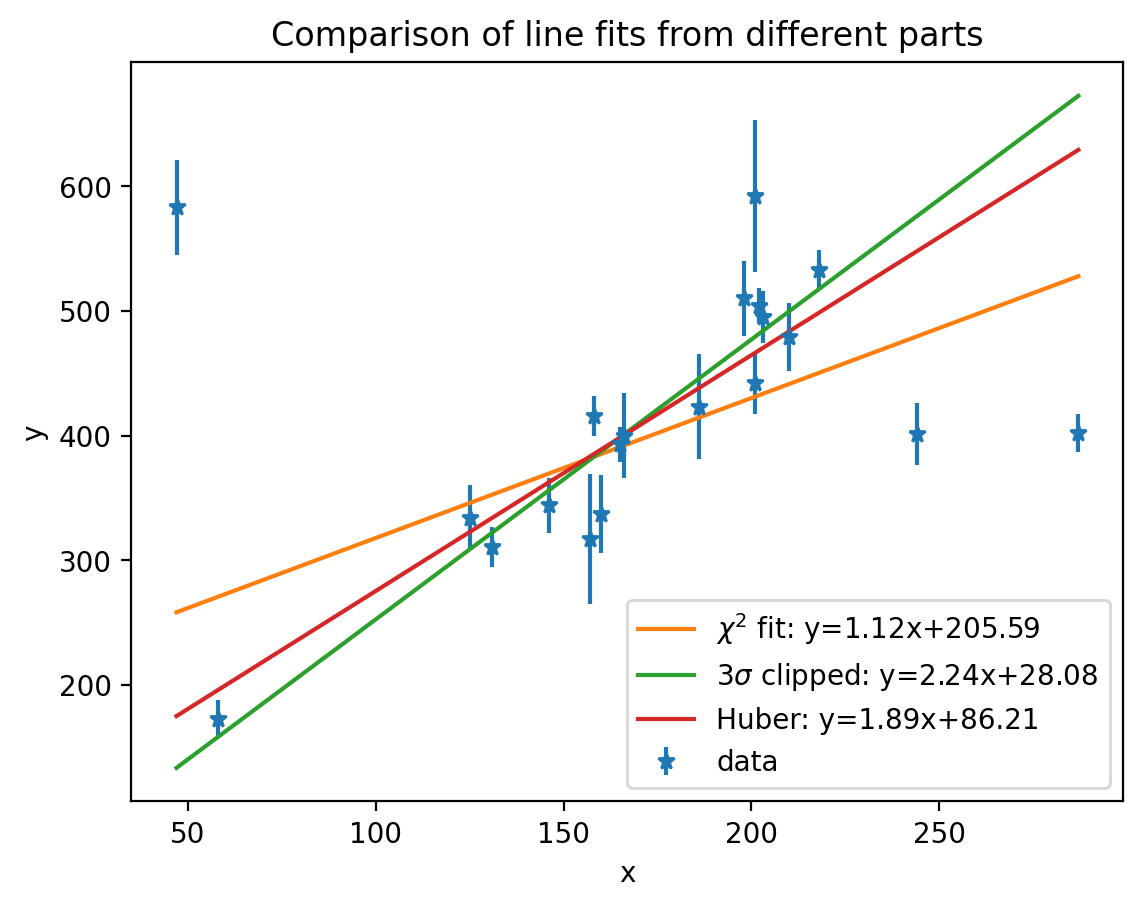

In [195]:
y_chi   = [a_best*x_vals[0] + b_best, a_best*x_vals[1] + b_best]
y_clip  = [a_masked*x_plot[0] + b_masked, a_masked*x_plot[1] + b_masked]
y_huber = [huber_slope*x_huber[0] + huber_intercept, huber_slope*x_huber[1] + huber_intercept]

plt.errorbar(x, y, yerr=dy, fmt='*', linestyle='none', label='data')
plt.plot(x_vals, y_chi, label=f'$\chi^2$ fit: y={a_best:.2f}x+{b_best:.2f}')
plt.plot(x_plot, y_clip, label=f'3$\sigma$ clipped: y={a_masked:.2f}x+{b_masked:.2f}')
plt.plot(x_huber, y_huber, label=f'Huber: y={huber_slope:.2f}x+{huber_intercept:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of line fits from different parts')
plt.legend() 
plt.show()

Text(0.5, 1.0, 'QQ plot after huber loss')

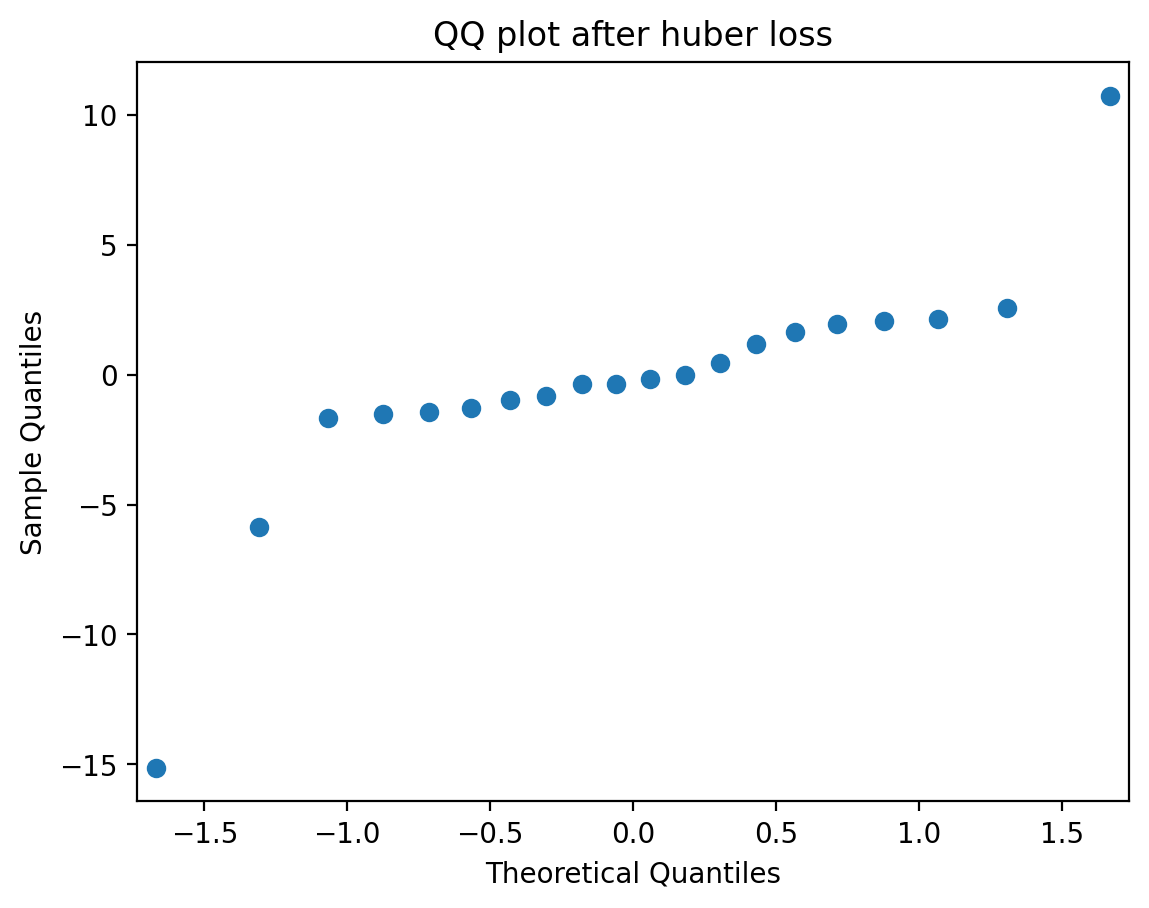

In [196]:
huber_res = (y - (huber_slope*x + huber_intercept)) / dy
sm.qqplot(np.array(huber_res))
plt.title("QQ plot after huber loss")

## Problem 2

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing. (15 pts)

In [210]:
#Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
#Fit or estimate straight lines to each of the four samples using your solution to Problem 1. (10 pts)

In [197]:
import pandas as pd
df = pd.read_csv("Cepheids.csv")
df

,name,RA0,Decl0,Mode,Cloud,W,logP1,VI
0,OGLE-LMC-CEP-0002,4.529733,-69.819330,F,LMC,14.52500,0.493893,0.740
1,OGLE-LMC-CEP-0005,4.592089,-69.734970,F,LMC,13.49540,0.749122,0.752
2,OGLE-LMC-CEP-0012,4.630203,-67.214420,F,LMC,14.54210,0.424912,0.598
3,OGLE-LMC-CEP-0016,4.642367,-67.646310,F,LMC,12.03300,1.021456,1.080
4,OGLE-LMC-CEP-0017,4.649119,-69.688390,F,LMC,14.34215,0.565524,0.647
...,...,...,...,...,...,...,...,...
7264,OGLE-SMC-CEP-4622,1.404808,-73.269361,1,SMC,15.94460,0.141140,0.648
7265,OGLE-SMC-CEP-4624,1.406767,-74.192639,1,SMC,15.29565,0.102449,0.577
7266,OGLE-SMC-CEP-4625,1.407181,-72.936056,1,SMC,15.33725,0.074740,0.485
7267,OGLE-SMC-CEP-4627,1.413575,-72.599167,1,SMC,14.06670,0.501477,0.686


In [199]:
df_LMC = df[df.Cloud == "LMC"]
df_SMC = df[df.Cloud == "SMC"]

In [203]:
df_LMC_F = df_LMC[df_LMC.Mode == 'F']
df_LMC_1 = df_LMC[df_LMC.Mode == '1']

In [204]:
df_SMC_F = df_SMC[df_SMC.Mode == 'F']
df_SMC_1 = df_SMC[df_SMC.Mode == '1']

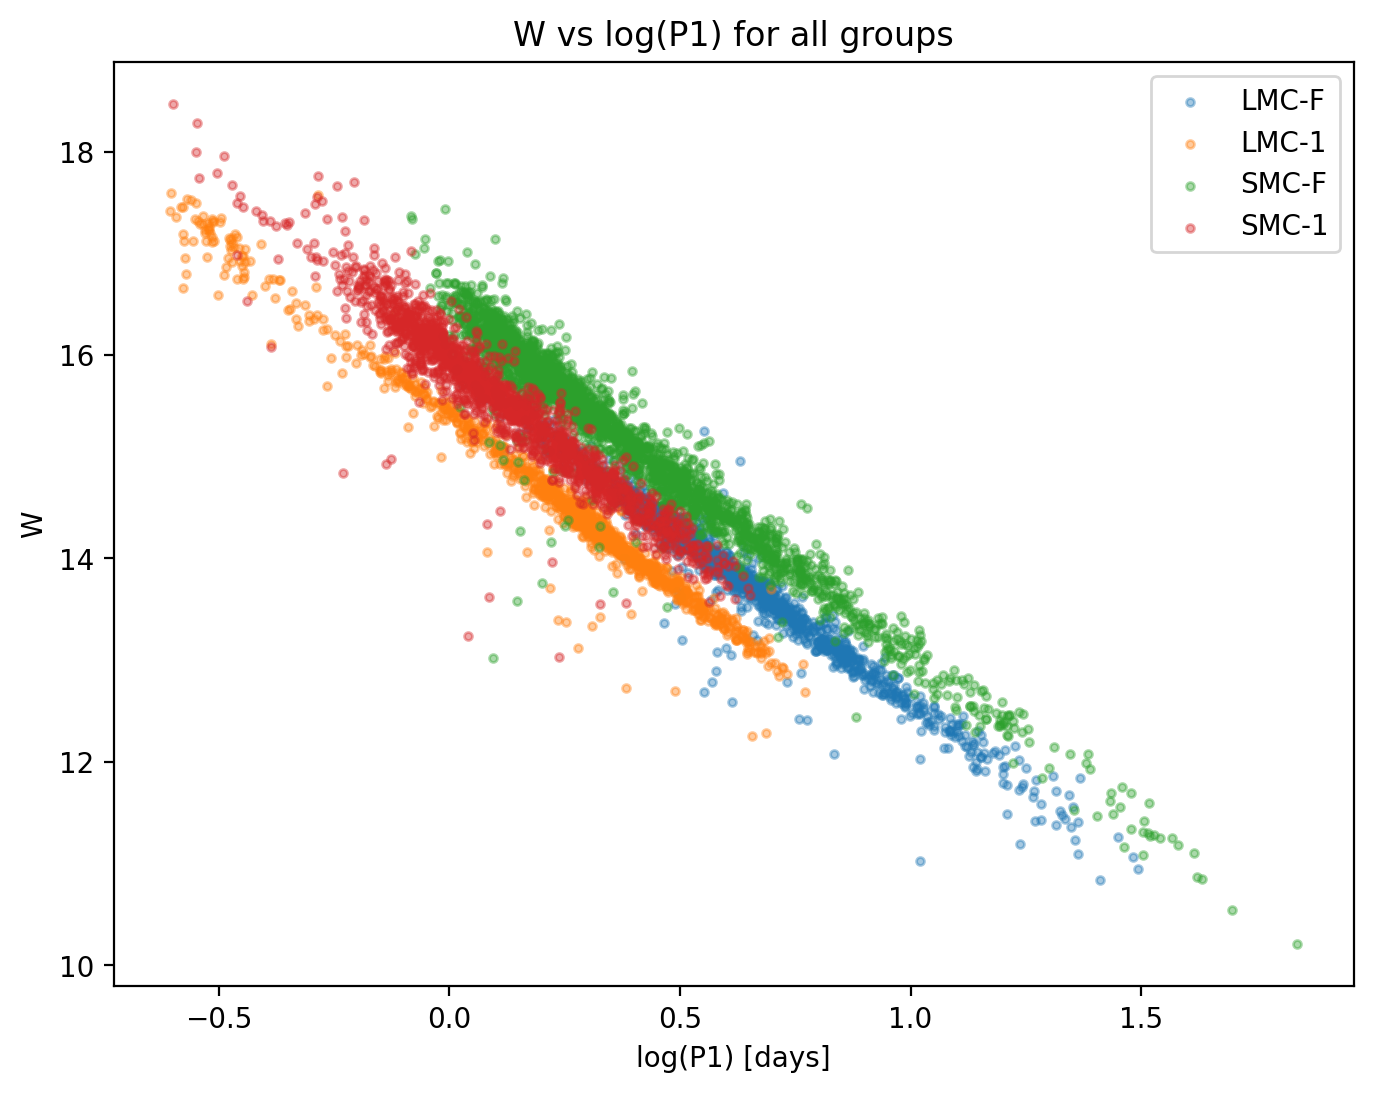

In [290]:
plt.figure(figsize=(8,6))
plt.scatter(df_LMC_F.logP1, df_LMC_F.W, s=8, alpha=0.4, label="LMC-F")
plt.scatter(df_LMC_1.logP1, df_LMC_1.W, s=8, alpha=0.4, label="LMC-1")
plt.scatter(df_SMC_F.logP1, df_SMC_F.W, s=8, alpha=0.4, label="SMC-F")
plt.scatter(df_SMC_1.logP1, df_SMC_1.W, s=8, alpha=0.4, label="SMC-1")
plt.xlabel("log(P1) [days]")
plt.ylabel("W")
plt.title("W vs log(P1) for all groups")
plt.legend()
plt.show()

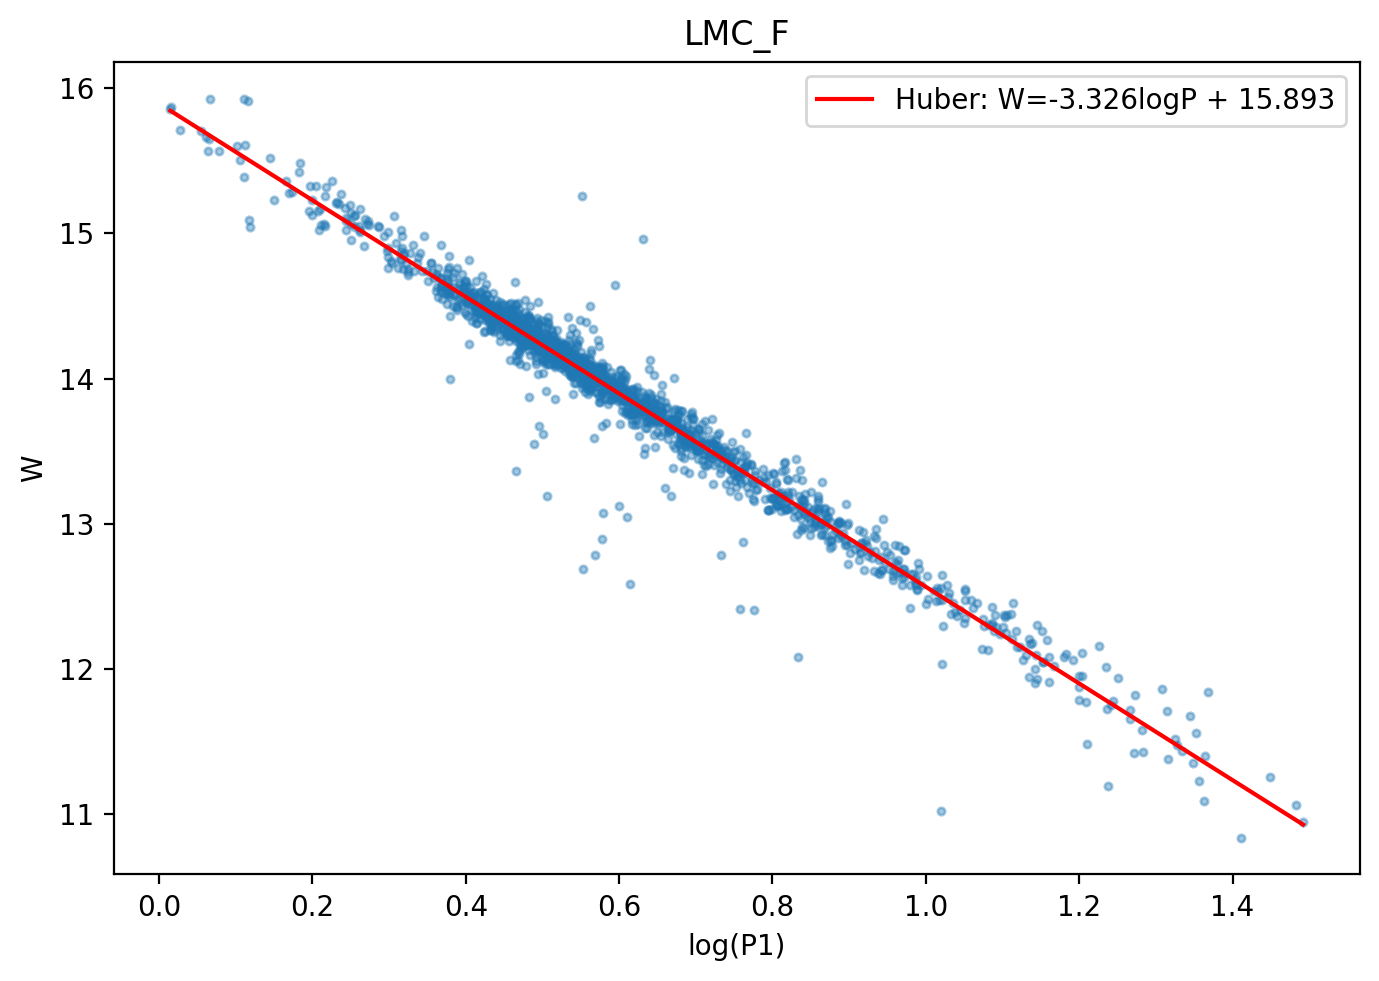

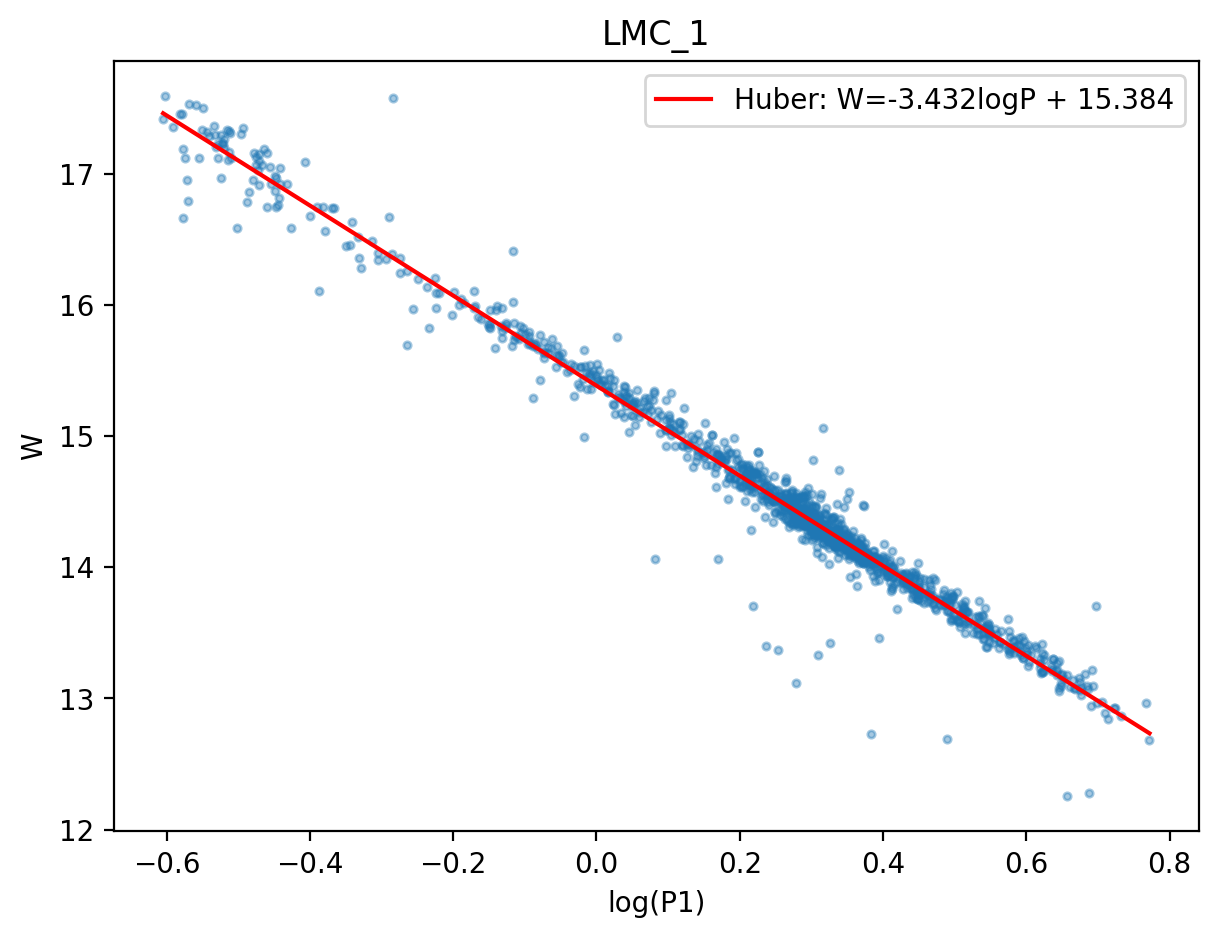

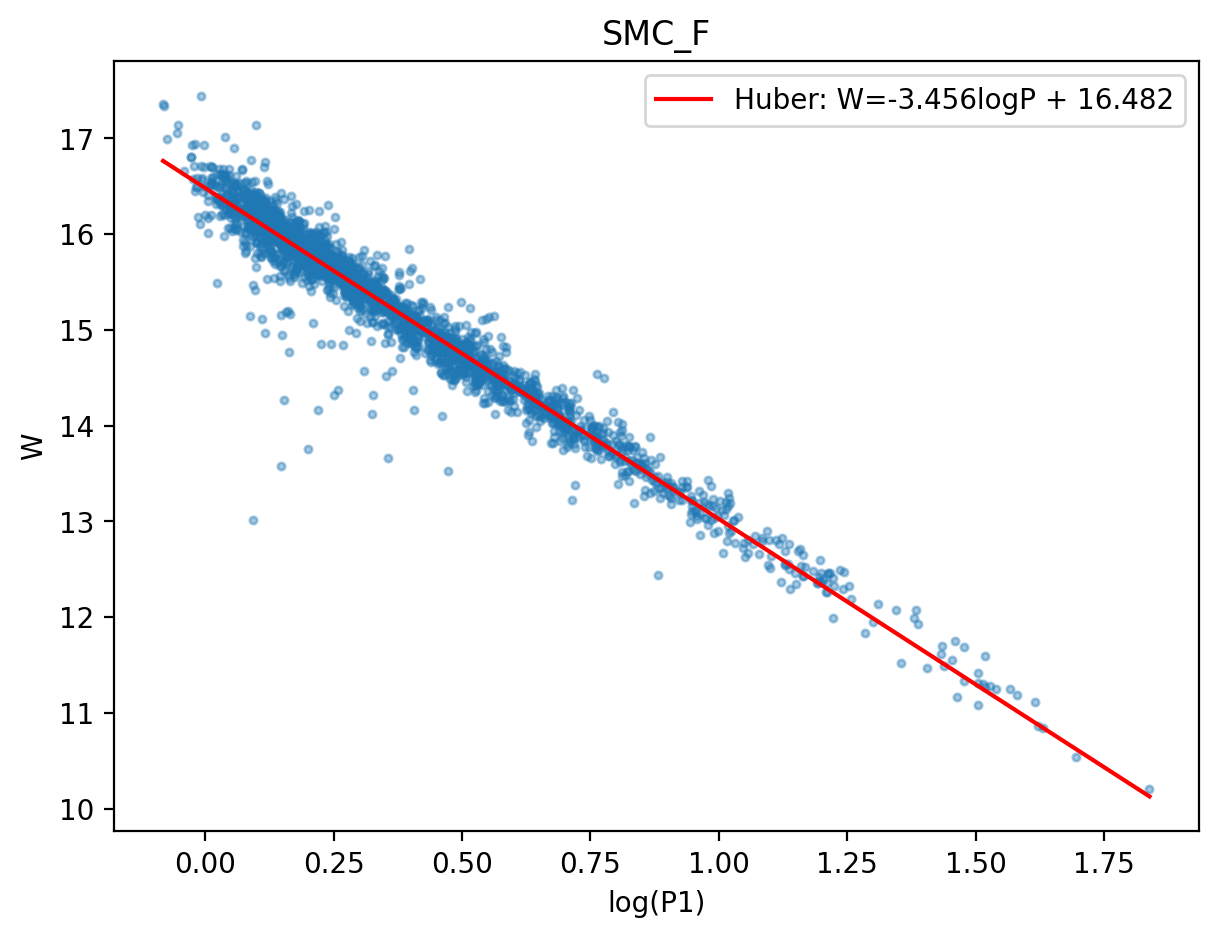

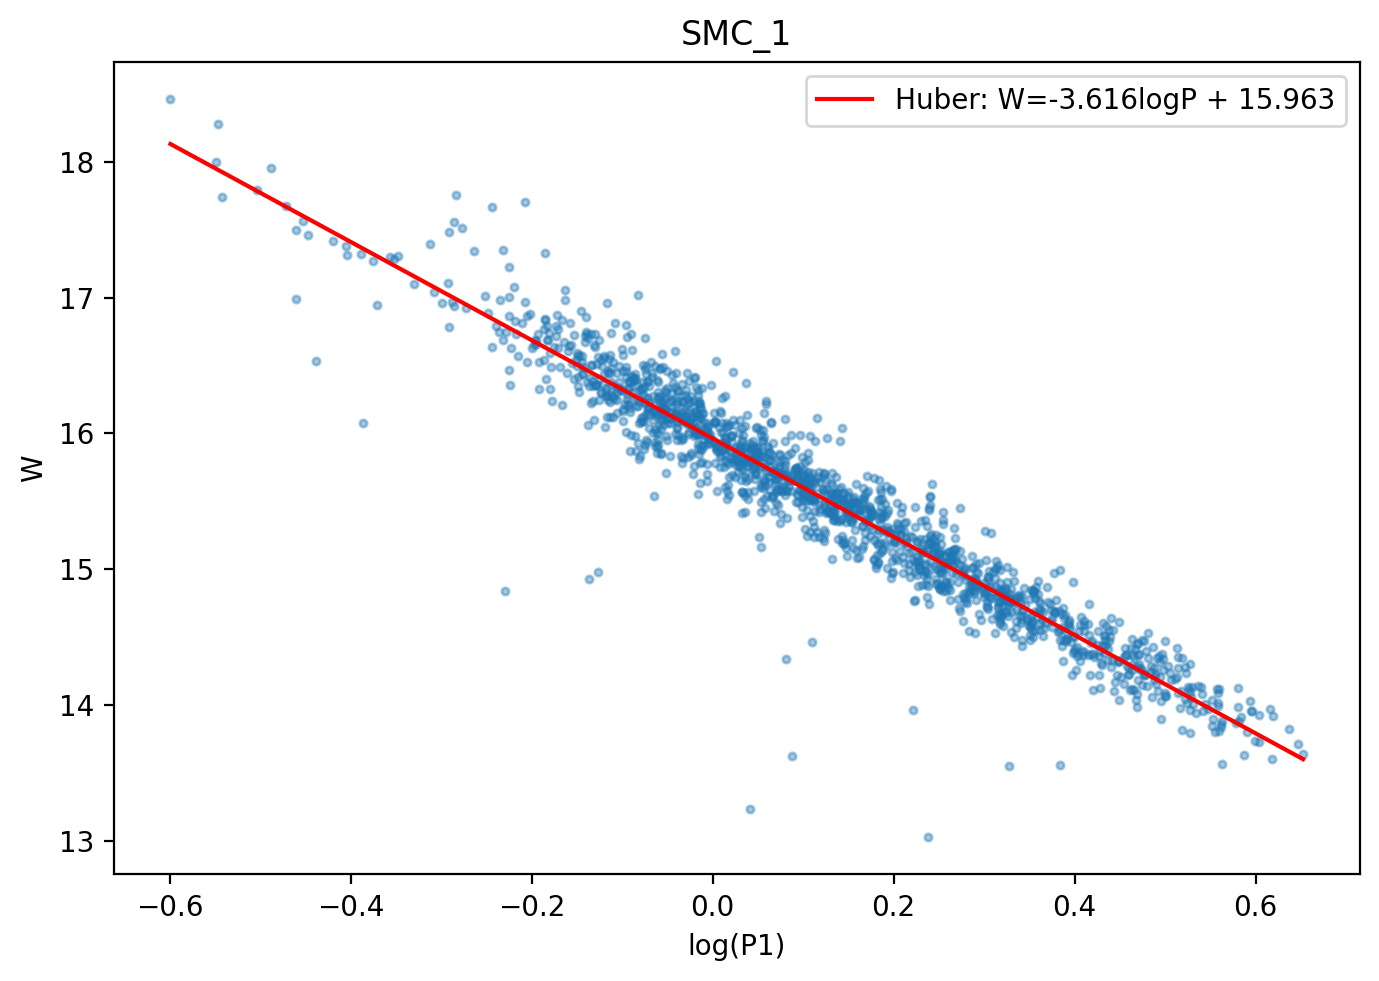

In [291]:
x = df_LMC_F["logP1"].values
y = df_LMC_F["W"].values
dy = np.ones_like(y)
guess = np.array([-4.0, 16.0])
a_LMC_F, b_LMC_F = fmin(huber, guess, args=(x, y, dy, 2.0), disp=False)
xline = np.array([x.min(), x.max()])
yline = a_LMC_F * xline + b_LMC_F
plt.figure(figsize=(7,5))
plt.scatter(x, y, s=7, alpha=0.4)
plt.plot(xline, yline, 'r-', label=f"Huber: W={a_LMC_F:.3f}logP + {b_LMC_F:.3f}")
plt.xlabel("log(P1)")
plt.ylabel("W")
plt.title("LMC_F")
plt.legend()
plt.tight_layout()
plt.show()

x = df_LMC_1["logP1"].values
y = df_LMC_1["W"].values
dy = np.ones_like(y)
guess = np.array([-4.0, 16.0])
a_LMC_1, b_LMC_1 = fmin(huber, guess, args=(x, y, dy, 2.0), disp=False)
xline = np.array([x.min(), x.max()])
yline = a_LMC_1 * xline + b_LMC_1
plt.figure(figsize=(7,5))
plt.scatter(x, y, s=7, alpha=0.4)
plt.plot(xline, yline, 'r-', label=f"Huber: W={a_LMC_1:.3f}logP + {b_LMC_1:.3f}")
plt.xlabel("log(P1)")
plt.ylabel("W")
plt.title("LMC_1")
plt.legend()
plt.show()

x = df_SMC_F["logP1"].values
y = df_SMC_F["W"].values
dy = np.ones_like(y)
guess = np.array([-4.0, 16.0])
a_SMC_F, b_SMC_F = fmin(huber, guess, args=(x, y, dy, 2.0), disp=False)
xline = np.array([x.min(), x.max()])
yline = a_SMC_F * xline + b_SMC_F
plt.figure(figsize=(7,5))
plt.scatter(x, y, s=7, alpha=0.4)
plt.plot(xline, yline, 'r-', label=f"Huber: W={a_SMC_F:.3f}logP + {b_SMC_F:.3f}")
plt.xlabel("log(P1)")
plt.ylabel("W")
plt.title("SMC_F")
plt.legend()
plt.show()

x = df_SMC_1["logP1"].values
y = df_SMC_1["W"].values
dy = np.ones_like(y)
guess = np.array([-4.0, 16.0])
a_SMC_1, b_SMC_1 = fmin(huber, guess, args=(x, y, dy, 2.0), disp=False)
xline = np.array([x.min(), x.max()])
yline = a_SMC_1 * xline + b_SMC_1
plt.figure(figsize=(7,5))
plt.scatter(x, y,  s=7, alpha=0.4)
plt.plot(xline, yline, 'r-', label=f"Huber: W={a_SMC_1:.3f}logP + {b_SMC_1:.3f}")
plt.xlabel("log(P1)")
plt.ylabel("W")
plt.title("SMC_1")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? 
# If not, speculate on why (WATCH THE YOUTUBE VIDEO!) (10 pts)

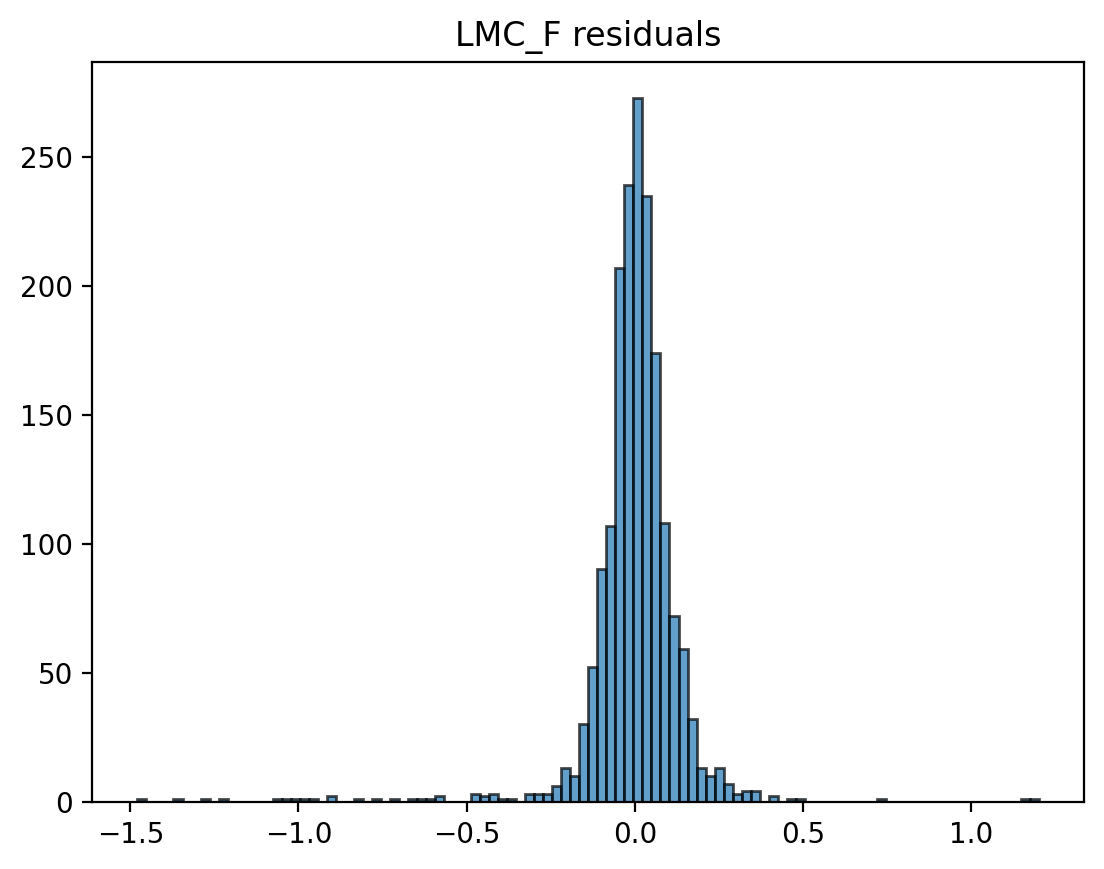

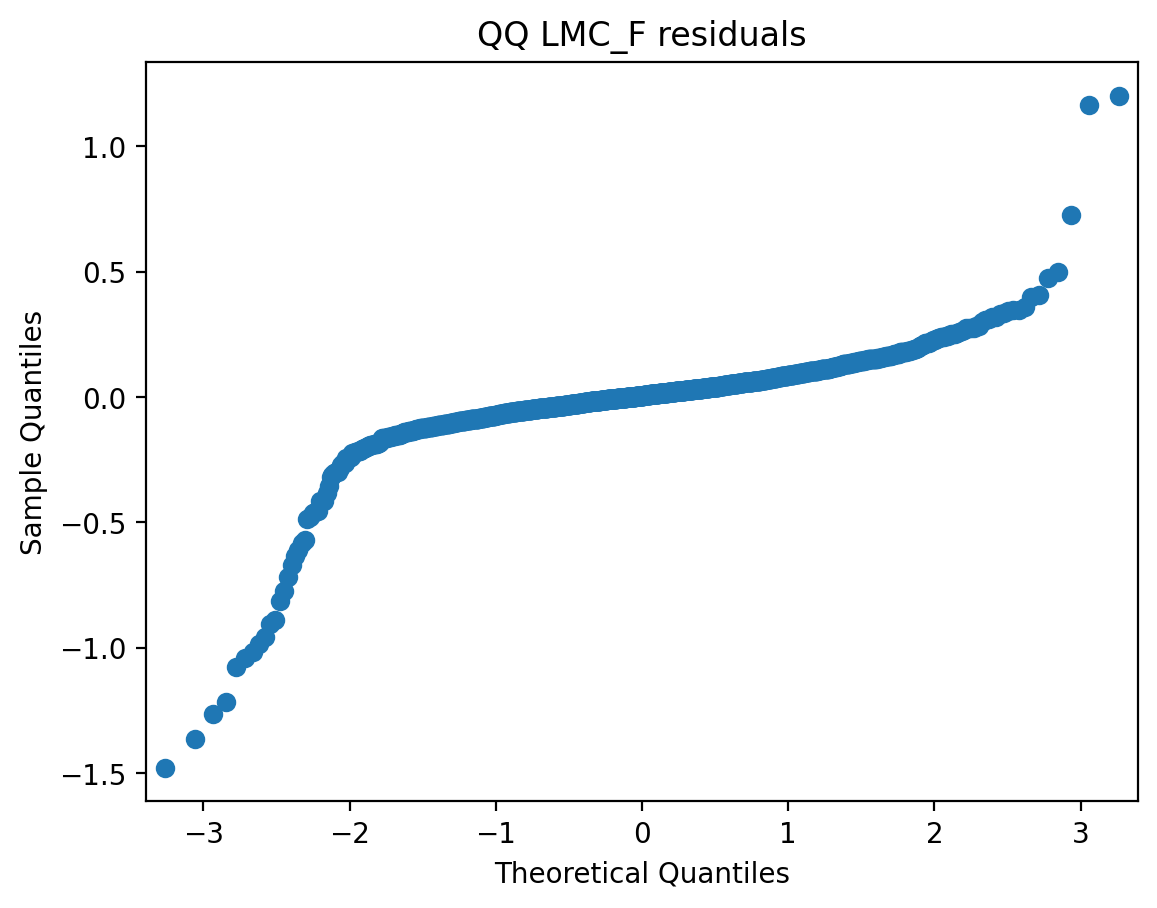

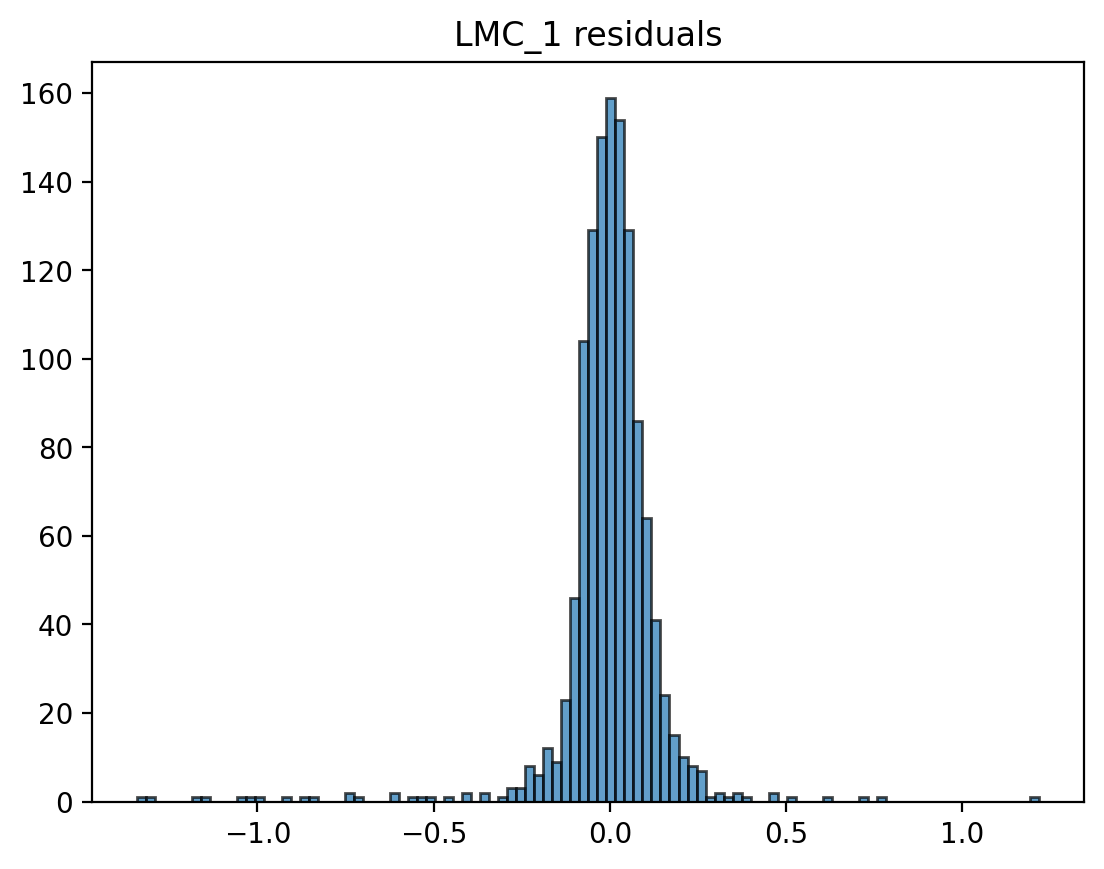

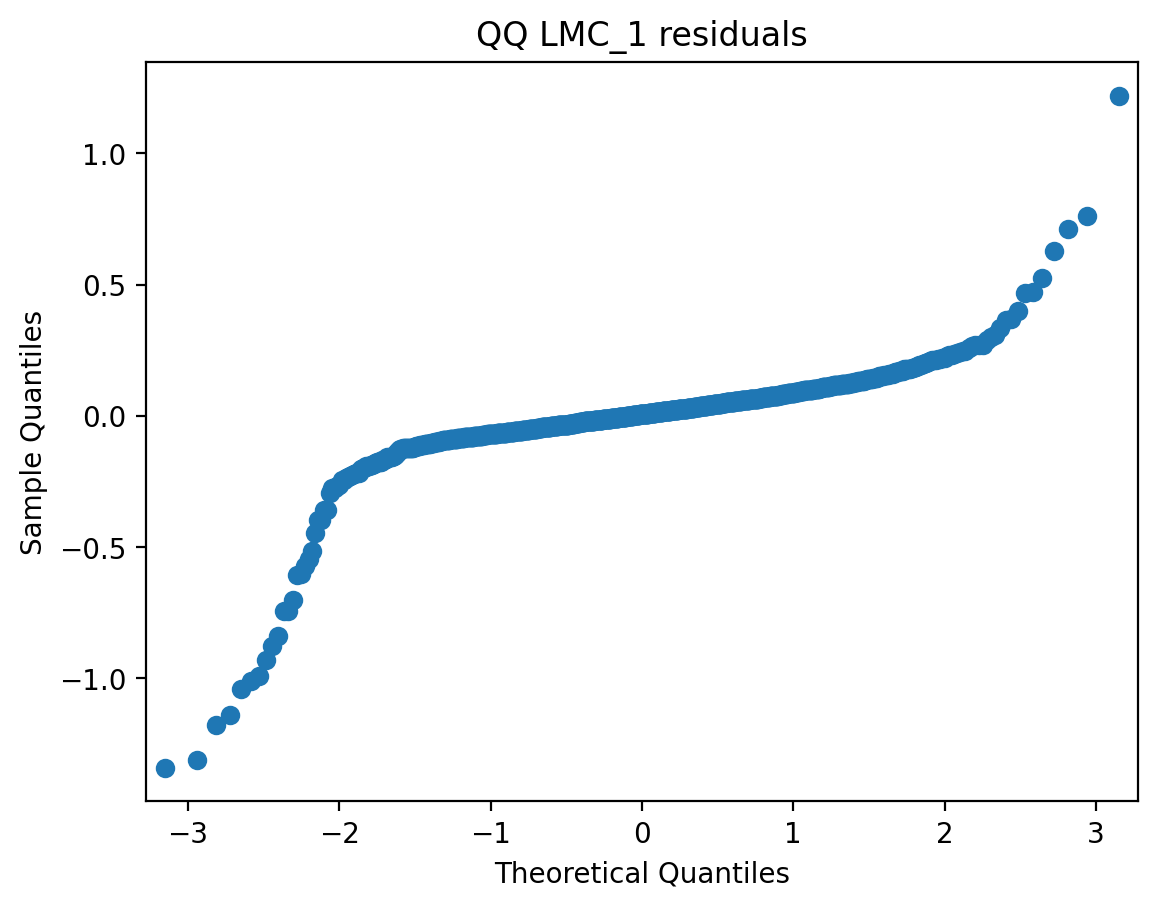

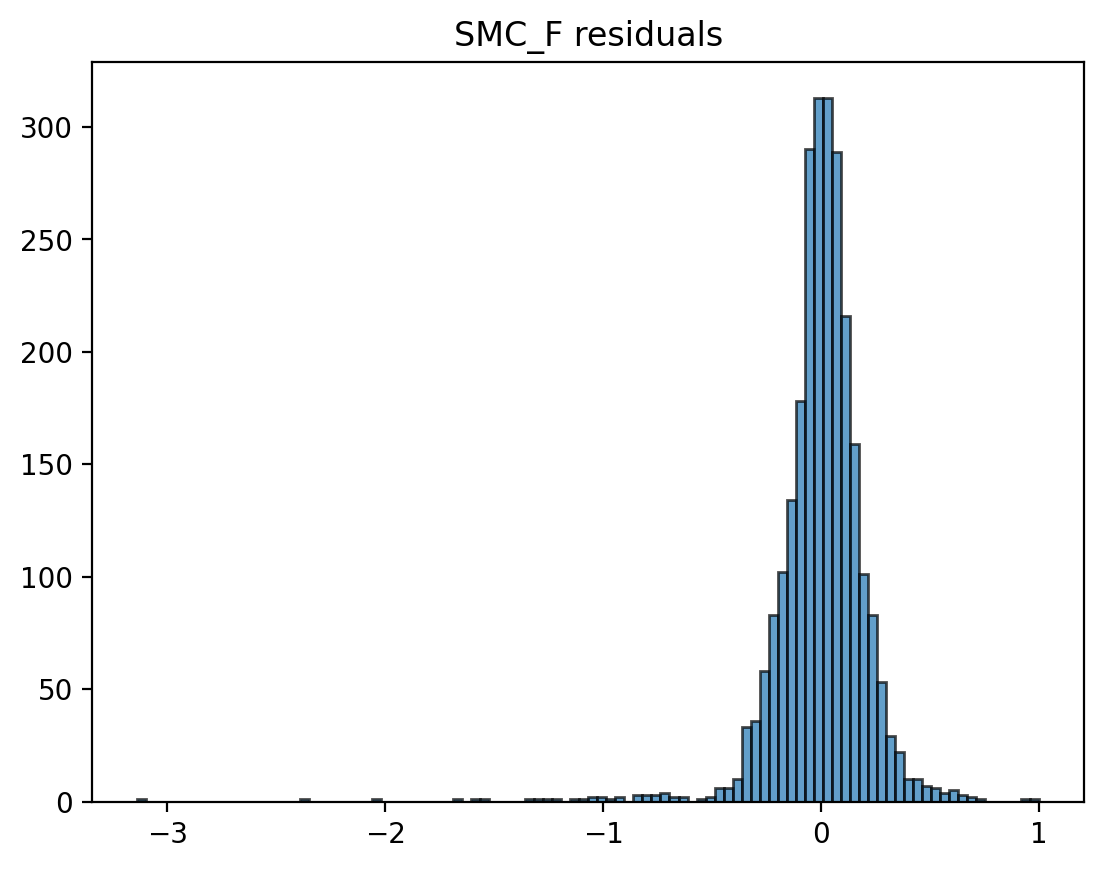

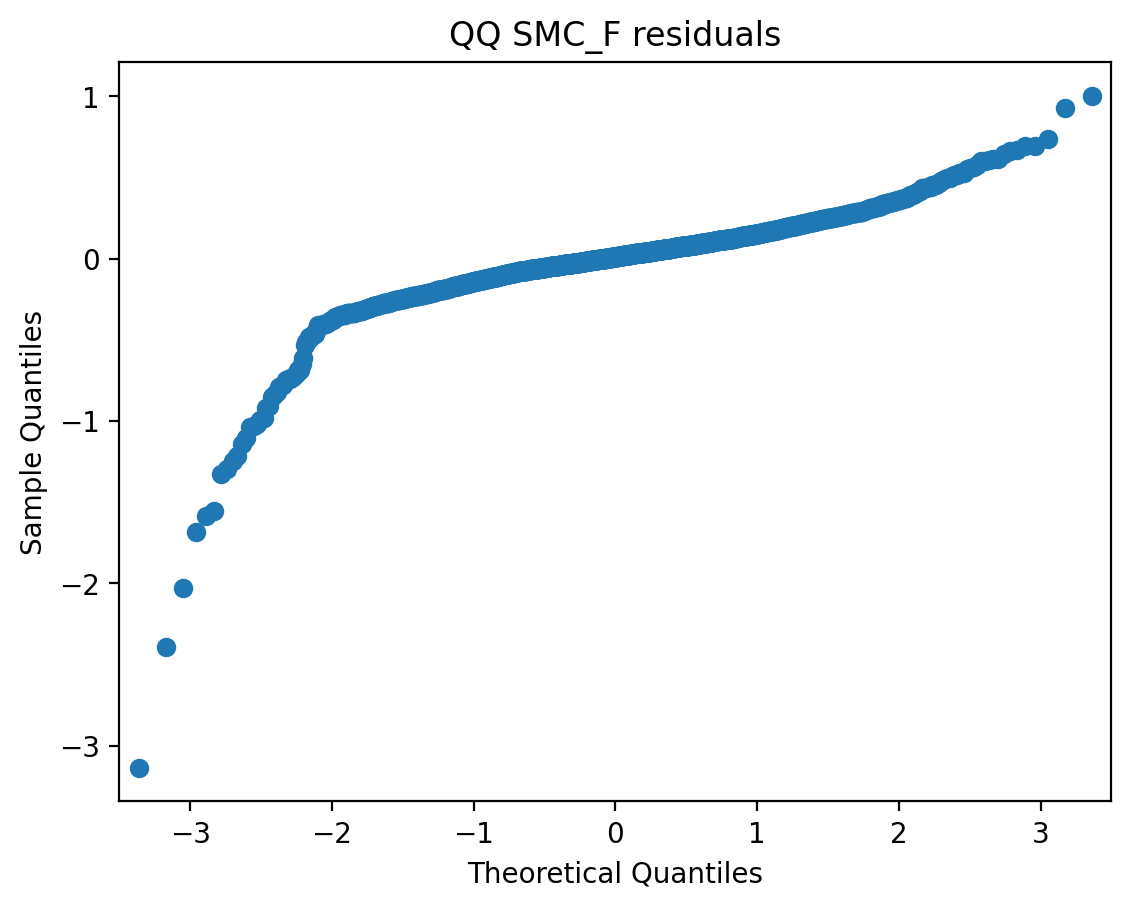

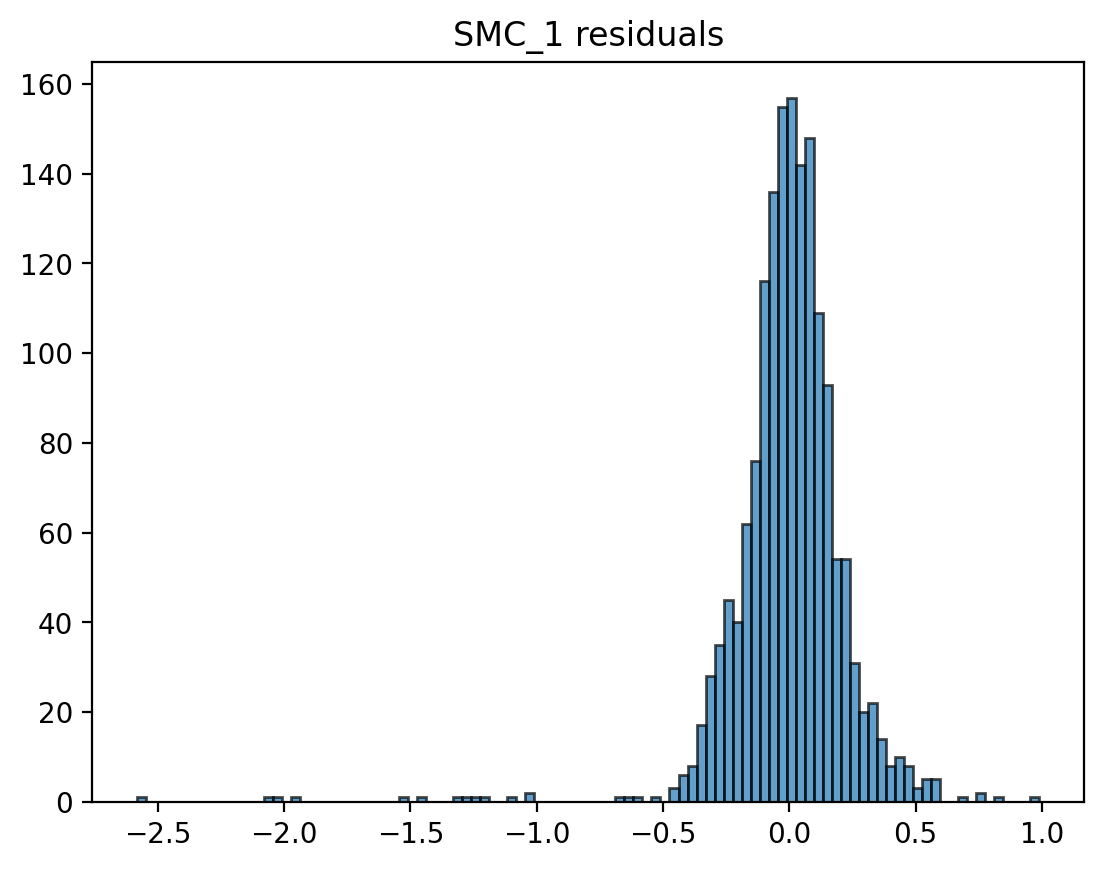

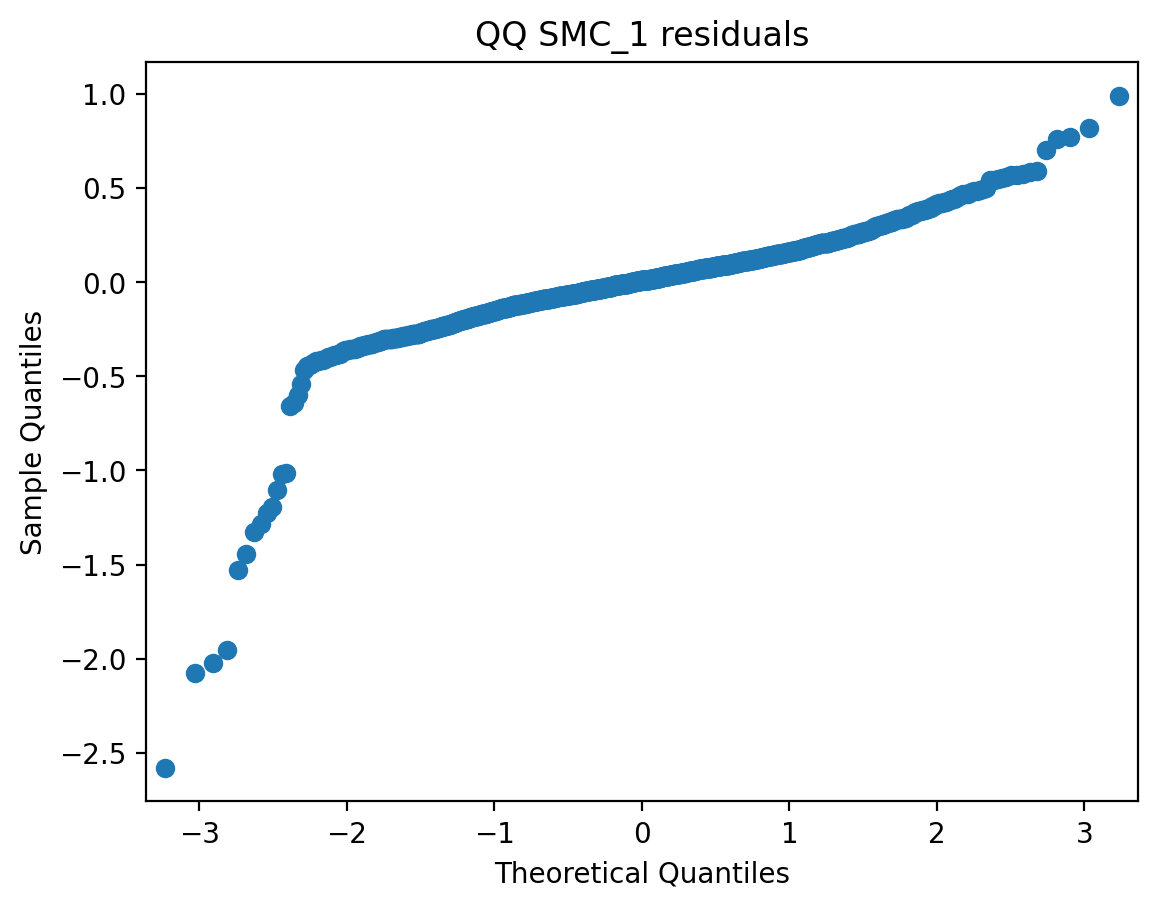

In [294]:
# LMC_F
x = df_LMC_F["logP1"].values
y = df_LMC_F["W"].values
res = y - (a_LMC_F * x + b_LMC_F)
plt.hist(res, bins=100, alpha=0.7, edgecolor="k")
plt.title("LMC_F residuals")
plt.show()
sm.qqplot(res)
plt.title("QQ LMC_F residuals")
plt.show()

# LMC_1
x = df_LMC_1["logP1"].values
y = df_LMC_1["W"].values
res = y - (a_LMC_1 * x + b_LMC_1)
plt.hist(res, bins=100, alpha=0.7, edgecolor="k")
plt.title("LMC_1 residuals")
plt.show()
sm.qqplot(res)
plt.title("QQ LMC_1 residuals")
plt.show()

# SMC_F
x = df_SMC_F["logP1"].values
y = df_SMC_F["W"].values
res = y - (a_SMC_F * x + b_SMC_F)
plt.hist(res, bins=100, alpha=0.7, edgecolor="k")
plt.title("SMC_F residuals")
plt.show()
sm.qqplot(res)
plt.title("QQ SMC_F residuals")
plt.show()

# SMC_1
x = df_SMC_1["logP1"].values
y = df_SMC_1["W"].values
res = y - (a_SMC_1 * x + b_SMC_1)
plt.hist(res, bins=100, alpha=0.7, edgecolor="k")
plt.title("SMC_1 residuals")
plt.show()
sm.qqplot(res)
plt.title("QQ SMC_1 residuals")
plt.show()

LMC seems to be fairly gaussian while SMC has some tailing ends. There is a sharp peak around 0 in all of them. We should also keep in mind our data is not accounting for any uncertainties at all. maybe its because these things are extremely well studied and a lot of data means the central limit theorem would kick in and make it vaguely gaussian which is whats happening. The non-gaussians or tails could be due to extinction or dust values but the W index is not affected by extinction so maybe some other variables or extra-galactic effects which we're not accounting for. space is weird so we never know

In [ ]:
#Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1). (15 pts)

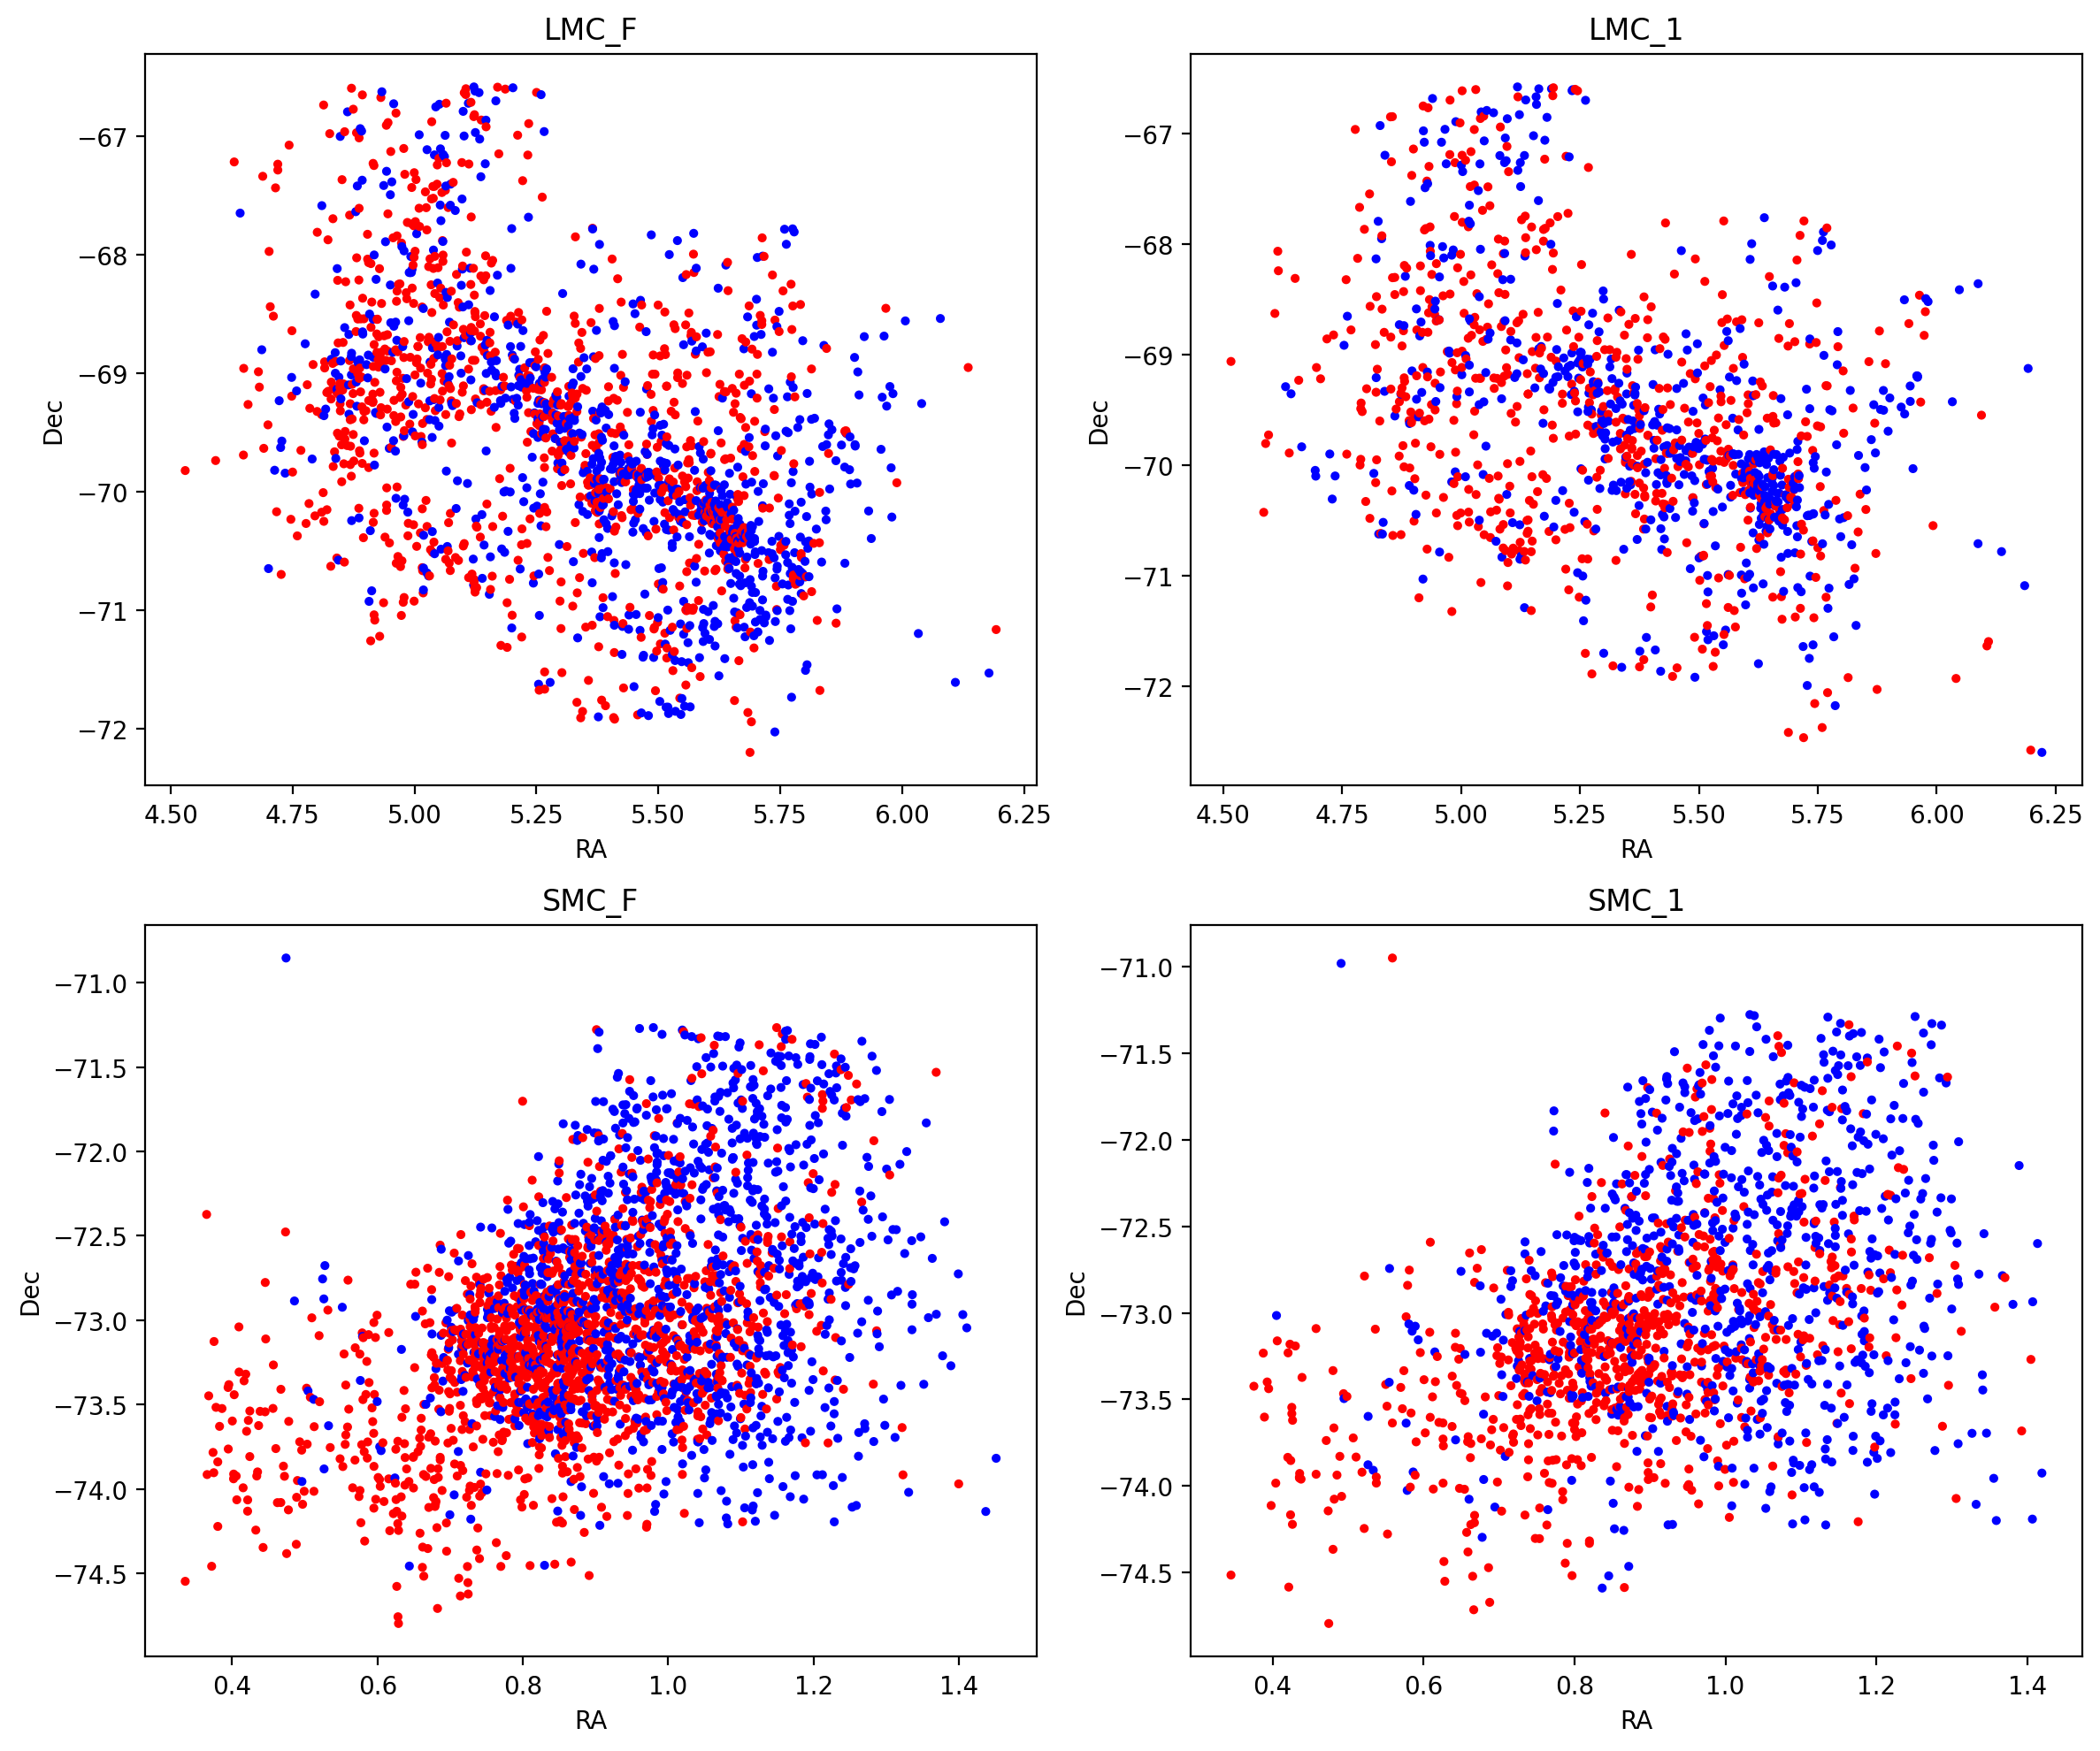

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

# LMC_F
x = df_LMC_F["logP1"].values
y = df_LMC_F["W"].values
res = y - (a_LMC_F * x + b_LMC_F)
ax[0,0].scatter(df_LMC_F["RA0"], df_LMC_F["Decl0"], c=np.sign(res), cmap="bwr", s=7)
ax[0,0].set_title("LMC_F")
ax[0,0].set_xlabel("RA")
ax[0,0].set_ylabel("Dec")

# LMC_1
x = df_LMC_1["logP1"].values
y = df_LMC_1["W"].values
res = y - (a_LMC_1 * x + b_LMC_1)
ax[0,1].scatter(df_LMC_1["RA0"], df_LMC_1["Decl0"], c=np.sign(res), cmap="bwr", s=7)
ax[0,1].set_title("LMC_1")
ax[0,1].set_xlabel("RA")
ax[0,1].set_ylabel("Dec")

# SMC_F
x = df_SMC_F["logP1"].values
y = df_SMC_F["W"].values
res = y - (a_SMC_F * x + b_SMC_F)
ax[1,0].scatter(df_SMC_F["RA0"], df_SMC_F["Decl0"], c=np.sign(res), cmap="bwr", s=7)
ax[1,0].set_title("SMC_F")
ax[1,0].set_xlabel("RA")
ax[1,0].set_ylabel("Dec")

# SMC_1
x = df_SMC_1["logP1"].values
y = df_SMC_1["W"].values
res = y - (a_SMC_1 * x + b_SMC_1)
ax[1,1].scatter(df_SMC_1["RA0"], df_SMC_1["Decl0"], c=np.sign(res), cmap="bwr", s=7)
ax[1,1].set_title("SMC_1")
ax[1,1].set_xlabel("RA")
ax[1,1].set_ylabel("Dec")
plt.tight_layout()
plt.show()

In [ ]:
#Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. 
#Comment on what you are seeing. (15 pts)

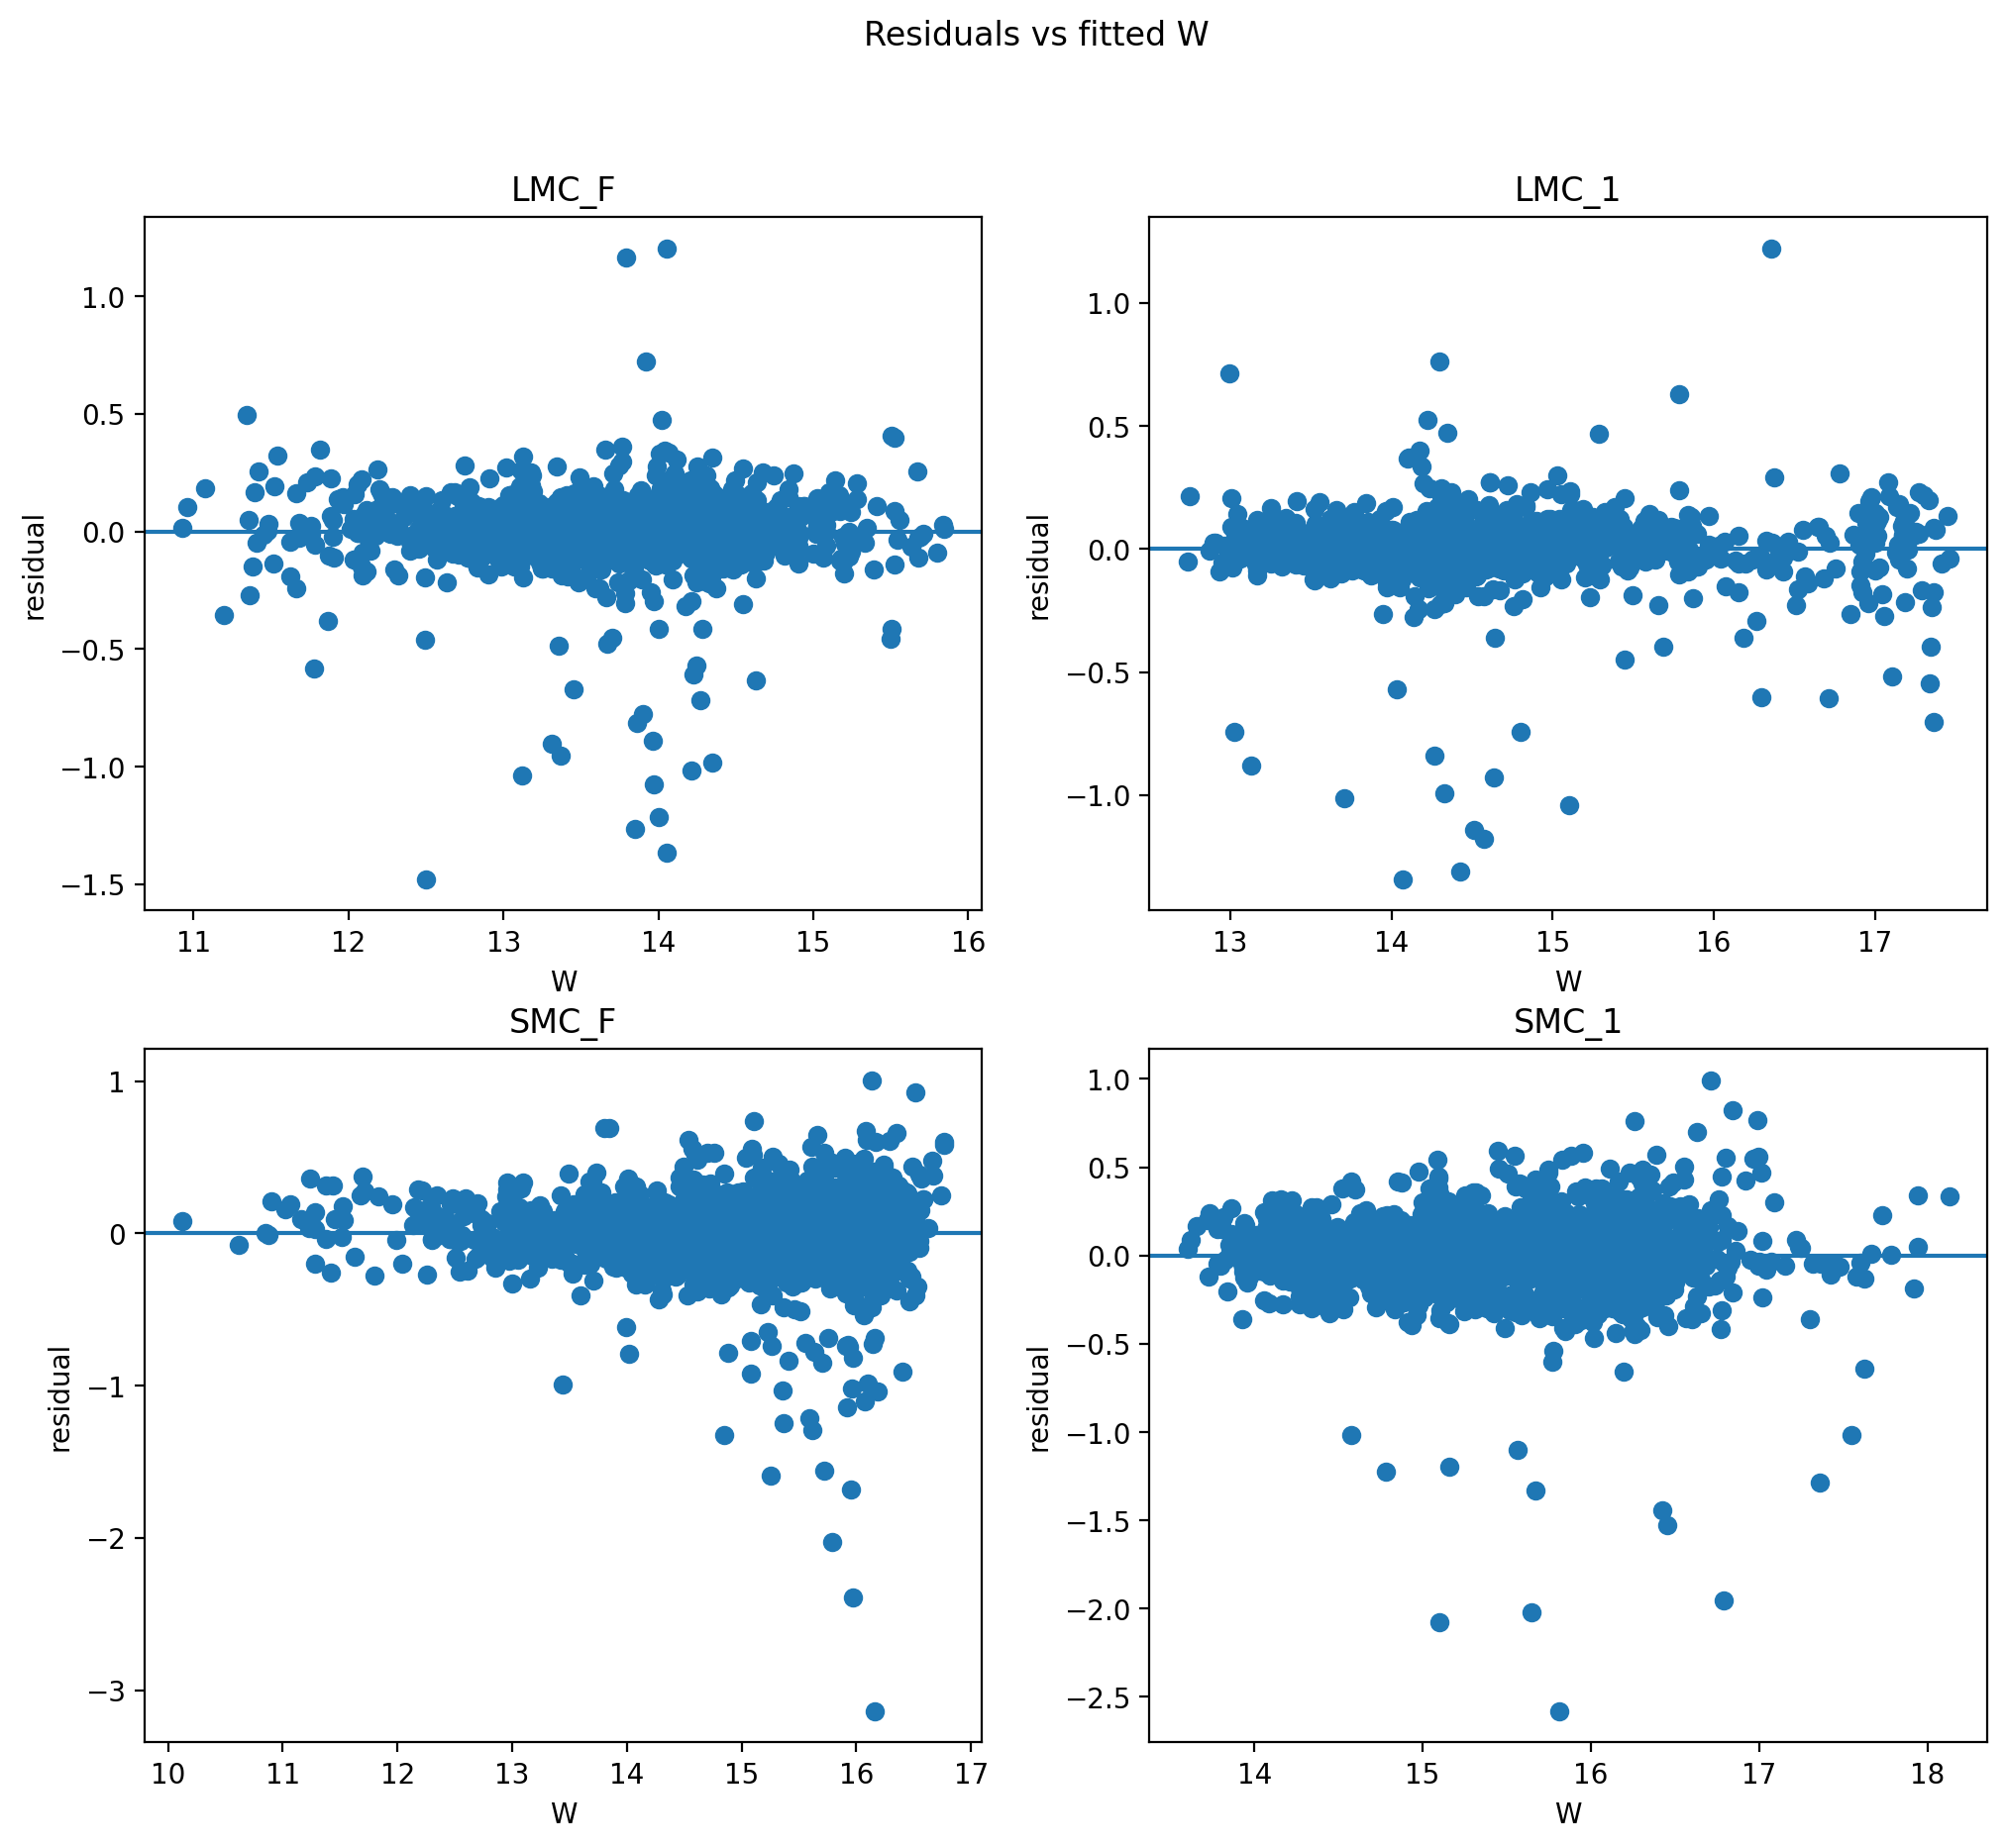

In [297]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
x = df_LMC_F["logP1"].values
y = df_LMC_F["W"].values
yhat = a_LMC_F * x + b_LMC_F
res = y - yhat
ax[0,0].axhline(0)
ax[0,0].scatter(yhat,  res)
ax[0,0].set_title("LMC_F")
ax[0,0].set_xlabel("W")
ax[0,0].set_ylabel("residual")

x = df_LMC_1["logP1"].values
y = df_LMC_1["W"].values
yhat = a_LMC_1 * x + b_LMC_1
res = y - yhat
ax[0,1].axhline(0)
ax[0,1].scatter(yhat, res)
ax[0,1].set_title("LMC_1")
ax[0,1].set_xlabel("W")
ax[0,1].set_ylabel("residual")

x = df_SMC_F["logP1"].values
y = df_SMC_F["W"].values
yhat = a_SMC_F * x + b_SMC_F
res = y - yhat
ax[1,0].axhline(0)
ax[1,0].scatter(yhat, res)
ax[1,0].set_title("SMC_F")
ax[1,0].set_xlabel("W")
ax[1,0].set_ylabel("residual")

x = df_SMC_1["logP1"].values
y = df_SMC_1["W"].values
yhat = a_SMC_1 * x + b_SMC_1
res = y - yhat
ax[1,1].axhline(0)
ax[1,1].scatter(yhat, res)
ax[1,1].set_title("SMC_1")
ax[1,1].set_xlabel("W")
ax[1,1].set_ylabel("residual")

fig.suptitle("Residuals vs fitted W")
plt.show()

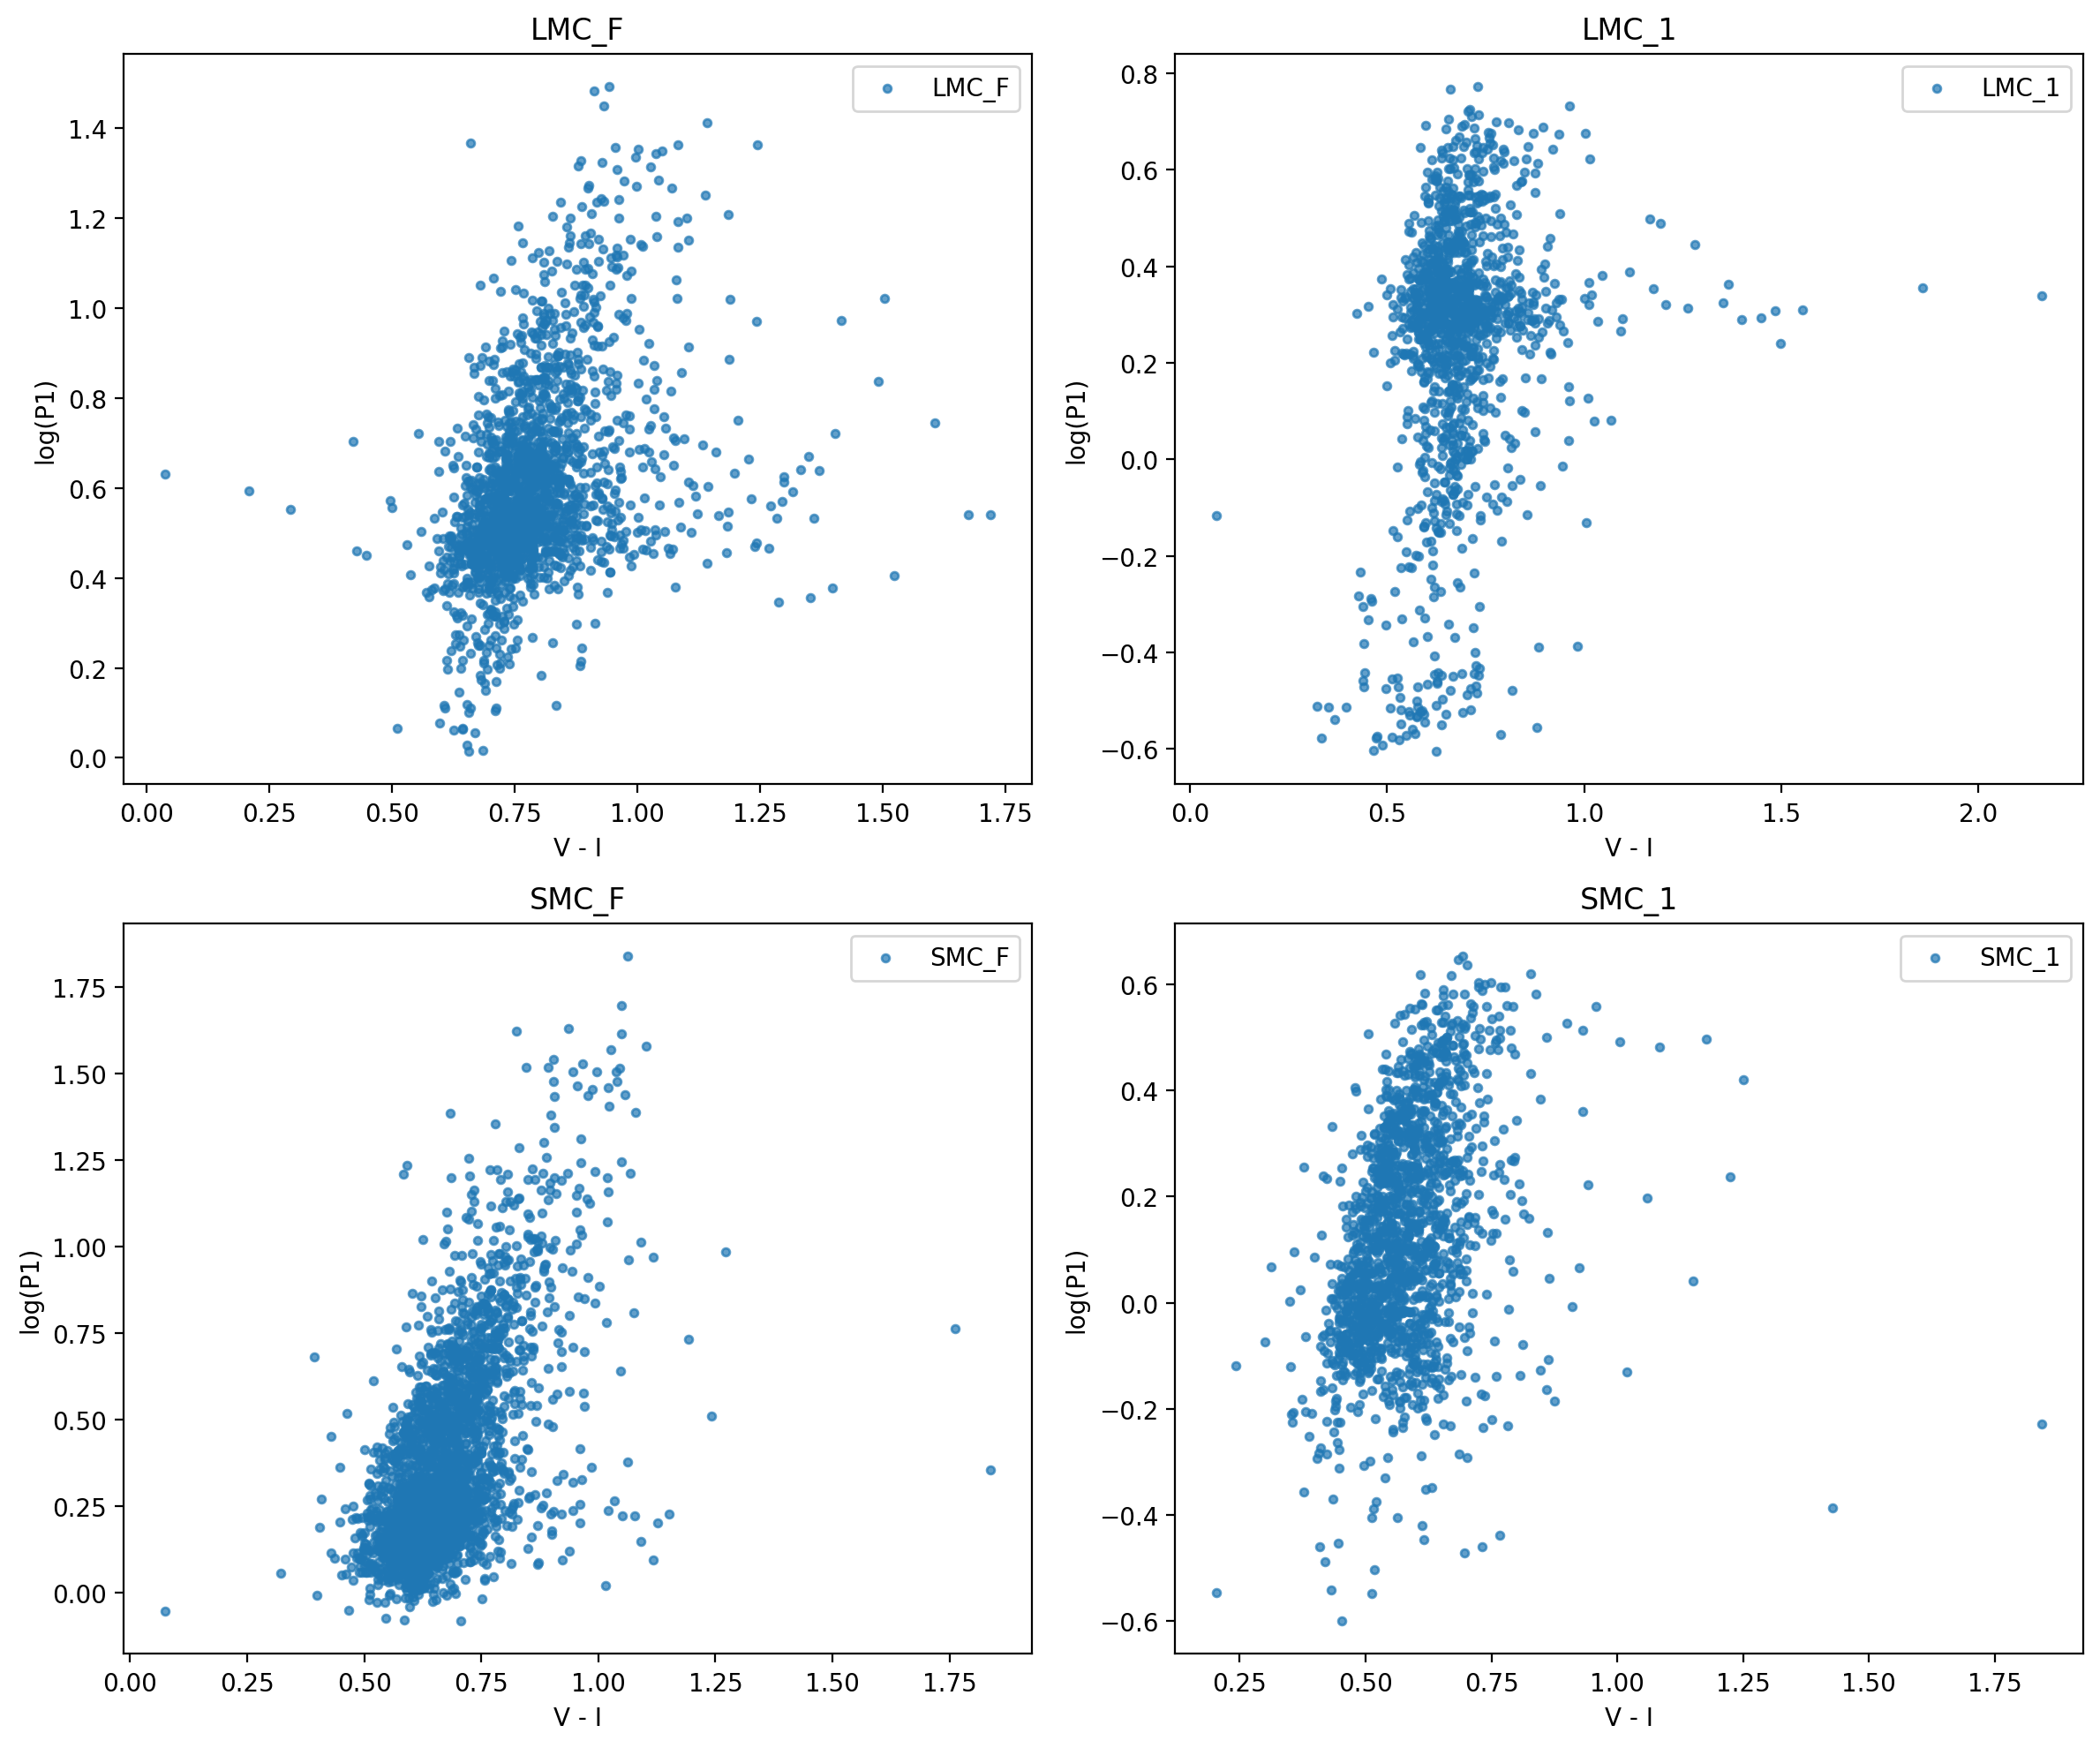

In [302]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].scatter(df_LMC_F["VI"], df_LMC_F["logP1"], alpha=0.7, s=10, label="LMC_F")
ax[0,0].set_xlabel("V - I")
ax[0,0].set_ylabel("log(P1)")
ax[0,0].set_title("LMC_F")
ax[0,0].legend()

ax[0,1].scatter(df_LMC_1["VI"], df_LMC_1["logP1"], alpha=0.7, s=10, label="LMC_1")
ax[0,1].set_xlabel("V - I")
ax[0,1].set_ylabel("log(P1)")
ax[0,1].set_title("LMC_1")
ax[0,1].legend()

ax[1,0].scatter(df_SMC_F["VI"], df_SMC_F["logP1"], alpha=0.7, s=10, label="SMC_F")
ax[1,0].set_xlabel("V - I")
ax[1,0].set_ylabel("log(P1)")
ax[1,0].set_title("SMC_F")
ax[1,0].legend()

ax[1,1].scatter(df_SMC_1["VI"], df_SMC_1["logP1"], alpha=0.7, s=10, label="SMC_1")
ax[1,1].set_xlabel("V - I")
ax[1,1].set_ylabel("log(P1)")
ax[1,1].set_title("SMC_1")
ax[1,1].legend()

plt.tight_layout()
plt.show()

This is very weird and confusing. for both there is clustering in different regions of the plots, plus it also stretches quite a bit so many VI values are possible. We also see a lot of scatter. I can't really pinpoint if i see a strong trend rather than what i just noted down. We also see the clustering of points in SMC are more around 0, while they do stretch a bit. LMC on the other hand is centered a bit higher than 0 and also stretching.